To dos:
TOC (headings, numbering)
Comments





#### Experiment design:
1. Input variables (X):
   - Surface meterlogy, Surface water temperature, Ice cover (from previous days), climate indices- 1995 onwards
    
2. Output variables (y):
   - Ice data (1995 onwards)
    
3. Period: 
   - 1996 to 2021 (25 years). Note that 1996 includes winter of 1995/1996
   - Training(60%) - 1996 to 2010
   - Validation(20%) - 2011 to 2015
   - Test(20%) - 2016 to 2021
    
4. Predict Interval:
   - Short term foreacast: 5 days and 7 days
   - Subseasonal forecast: 5 weeks (35 days) 
    
5. Preperation of input data:
   - Surface meterology: daily frequency data - 7 day(168 hours) history data/lag
   - Ice data: daily frequency - 7 day history/lag
   - Water Surface temperature: daily - 7 day history/lag
   - Climate indices: monthly - 3 month history/lag + daily - 7 day lag
   
            Example : If today is 1st Nov at 12 EST then inputs will be...
                  - Surface met: 25th Oct 6 EST to 1st Nov 6 EST
                  - Ice data: 25th Oct to 31st Oct
                  - Water surface temperature: 25th Oct to 31st Oct
                  - Climate indices: July,Aug,Sep
    - Note that the lag periods(7 days/3 months) can be tested in the Hyperparameter tuning phase

### 1. Preperation of Input data

In [1]:
%pip install altair vega_datasets

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import math
import matplotlib.pyplot as plt
%matplotlib inline   
pd.plotting.register_matplotlib_converters()           
import seaborn as sns  
import altair as alt
from vega_datasets import data
import xgboost as xgb
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [3]:
meterology = pd.read_excel("C:/Users/santh/MIDAS/Final_data/meteorlogy_daily.xlsx")
surface_temp = pd.read_csv("C:/Users/santh/MIDAS/Final_data/Surface_Temperature_Without_Remove.csv", usecols=['Date', 'Sup.', 'Huron'], 
                           dtype= {'Sup.':float, 'Huron':float})
ice_data = pd.read_excel("C:/Users/santh/MIDAS/Final_data/ice_data_without_remove.xlsx")
climate_ind_m = pd.read_csv("C:/Users/santh/MIDAS/Final_data/Climate_indices.csv")

In [4]:
meterology.head()

,date,u-wind,v-wind,pressure,humidity,temperature
0,1995-01-01,2.381250,-0.628125,98903.125,30.375,270.178146
1,1995-01-02,4.033125,-1.283125,98336.875,25.500,267.714500
2,1995-01-03,5.938750,0.482500,98652.500,17.125,265.636627
3,1995-01-04,3.722500,-1.425625,99073.125,7.375,259.524513
4,1995-01-05,7.392500,2.583125,98769.375,16.625,264.535141


In [5]:
meterology.dtypes

date           datetime64[ns]
u-wind                float64
v-wind                float64
pressure              float64
humidity              float64
temperature           float64
dtype: object

In [6]:
meterology = meterology.set_index('date')
meterology.head()

,u-wind,v-wind,pressure,humidity,temperature
date,,,,,
1995-01-01,2.381250,-0.628125,98903.125,30.375,270.178146
1995-01-02,4.033125,-1.283125,98336.875,25.500,267.714500
1995-01-03,5.938750,0.482500,98652.500,17.125,265.636627
1995-01-04,3.722500,-1.425625,99073.125,7.375,259.524513
1995-01-05,7.392500,2.583125,98769.375,16.625,264.535141


In [7]:
meterology1 = meterology

In [8]:
look_back = 4 ############## This will create only 3 lags for all features since the training data contains only 5844 records.Creating addtional lags will increase the no. of features vs. less records
predict_interval = 7

In [9]:
lags = range(1, look_back)

meterology = meterology.assign(**{
    f'{col}{lag}': meterology[col].shift(lag)
    for lag in lags
    for col in meterology
})

meterology.head(10)

,u-wind,v-wind,pressure,humidity,temperature,u-wind1,v-wind1,pressure1,humidity1,temperature1,u-wind2,v-wind2,pressure2,humidity2,temperature2,u-wind3,v-wind3,pressure3,humidity3,temperature3
date,,,,,,,,,,,,,,,,,,,,
1995-01-01,2.381250,-0.628125,98903.125,30.375,270.178146,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1995-01-02,4.033125,-1.283125,98336.875,25.500,267.714500,2.381250,-0.628125,98903.125,30.375,270.178146,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1995-01-03,5.938750,0.482500,98652.500,17.125,265.636627,4.033125,-1.283125,98336.875,25.500,267.714500,2.381250,-0.628125,98903.125,30.375,270.178146,NaN,NaN,NaN,NaN,NaN
1995-01-04,3.722500,-1.425625,99073.125,7.375,259.524513,5.938750,0.482500,98652.500,17.125,265.636627,4.033125,-1.283125,98336.875,25.500,267.714500,2.381250,-0.628125,98903.125,30.375,270.178146
1995-01-05,7.392500,2.583125,98769.375,16.625,264.535141,3.722500,-1.425625,99073.125,7.375,259.524513,5.938750,0.482500,98652.500,17.125,265.636627,4.033125,-1.283125,98336.875,25.500,267.714500
1995-01-06,5.763750,2.210625,97803.125,36.500,269.011017,7.392500,2.583125,98769.375,16.625,264.535141,3.722500,-1.425625,99073.125,7.375,259.524513,5.938750,0.482500,98652.500,17.125,265.636627
1995-01-07,0.098125,-3.118125,98220.000,8.000,262.210144,5.763750,2.210625,97803.125,36.500,269.011017,7.392500,2.583125,98769.375,16.625,264.535141,3.722500,-1.425625,99073.125,7.375,259.524513
1995-01-08,3.726875,2.000625,98293.750,11.625,264.712128,0.098125,-3.118125,98220.000,8.000,262.210144,5.763750,2.210625,97803.125,36.500,269.011017,7.392500,2.583125,98769.375,16.625,264.535141
1995-01-09,4.055000,-0.819375,99311.875,8.125,262.844383,3.726875,2.000625,98293.750,11.625,264.712128,0.098125,-3.118125,98220.000,8.000,262.210144,5.763750,2.210625,97803.125,36.500,269.011017


In [10]:
surface_temp.head()

,Date,Sup.,Huron
0,1995/1/1 0:00,3.29,4.50
1,1995/1/2 0:00,3.28,4.45
2,1995/1/3 0:00,3.27,4.39
3,1995/1/4 0:00,3.27,4.33
4,1995/1/5 0:00,3.22,4.18


In [11]:
surface_temp.dtypes

Date      object
Sup.     float64
Huron    float64
dtype: object

In [12]:
surface_temp['Date'] = pd.to_datetime(surface_temp['Date'], errors = 'coerce')
surface_temp.head()

,Date,Sup.,Huron
0,1995-01-01,3.29,4.50
1,1995-01-02,3.28,4.45
2,1995-01-03,3.27,4.39
3,1995-01-04,3.27,4.33
4,1995-01-05,3.22,4.18


In [13]:
surface_temp = surface_temp.set_index('Date')
surface_temp.head()

,Sup.,Huron
Date,,
1995-01-01,3.29,4.50
1995-01-02,3.28,4.45
1995-01-03,3.27,4.39
1995-01-04,3.27,4.33
1995-01-05,3.22,4.18


In [14]:
surface_temp1 = surface_temp

In [15]:
lags = range(1, look_back)

surface_temp = surface_temp.assign(**{
    f'{col}{lag}': surface_temp[col].shift(lag)
    for lag in lags
    for col in surface_temp
})

surface_temp.head(10)

,Sup.,Huron,Sup.1,Huron1,Sup.2,Huron2,Sup.3,Huron3
Date,,,,,,,,
1995-01-01,3.29,4.50,NaN,NaN,NaN,NaN,NaN,NaN
1995-01-02,3.28,4.45,3.29,4.50,NaN,NaN,NaN,NaN
1995-01-03,3.27,4.39,3.28,4.45,3.29,4.50,NaN,NaN
1995-01-04,3.27,4.33,3.27,4.39,3.28,4.45,3.29,4.50
1995-01-05,3.22,4.18,3.27,4.33,3.27,4.39,3.28,4.45
1995-01-06,3.19,4.06,3.22,4.18,3.27,4.33,3.27,4.39
1995-01-07,3.14,3.90,3.19,4.06,3.22,4.18,3.27,4.33
1995-01-08,3.10,3.75,3.14,3.90,3.19,4.06,3.22,4.18
1995-01-09,3.02,3.59,3.10,3.75,3.14,3.90,3.19,4.06


In [16]:
climate_ind_m.head()

,dateTime,NAO,PNA,EPNP,SOI
0,1995-01-01,0.93,0.66,1.03,-0.4
1,1995-02-01,1.14,0.73,0.05,-0.1
2,1995-03-01,1.25,0.33,0.61,0.8
3,1995-04-01,-0.85,0.29,1.13,-0.7
4,1995-05-01,-1.49,0.01,0.72,-0.4


In [17]:
climate_ind_m.dtypes

dateTime     object
NAO         float64
PNA         float64
EPNP        float64
SOI         float64
dtype: object

Observation - Climate indices data is of monthly frequency whereas the rest of the indices are of daily frequency. Hence, we need to convert the Climate indices data to daily frequency inorder to create the consolidated input file.

In [18]:
#Inorder to Upsample the Climate indices data, the dateTime feature has to be an index and has to be a datetime object. 
climate_ind_m['dateTime'] = pd.to_datetime(climate_ind_m['dateTime'], errors='coerce')
climate_ind_m.set_index('dateTime', inplace=True)
climate_ind_m.head()

,NAO,PNA,EPNP,SOI
dateTime,,,,
1995-01-01,0.93,0.66,1.03,-0.4
1995-02-01,1.14,0.73,0.05,-0.1
1995-03-01,1.25,0.33,0.61,0.8
1995-04-01,-0.85,0.29,1.13,-0.7
1995-05-01,-1.49,0.01,0.72,-0.4


In [19]:
#Resample at daily frequnecy, use the start value(in a month) to forward fill for the rest of the days in the month
climate_ind_d = climate_ind_m.resample('D', convention='start').ffill()
climate_ind_d.value_counts()

NAO    PNA    EPNP   SOI 
-3.18   0.76   0.23  -1.1    31
 0.61   0.69  -0.03   2.5    31
 0.19  -0.40  -0.58   0.9    31
       -0.05  -0.32   0.0    31
 0.20   0.41  -0.24   1.0    31
                             ..
 0.29  -0.12  -1.12   1.0    28
 0.45  -0.16   0.26   1.7    28
 0.70  -1.58  -0.12   2.7    28
 1.10   0.14  -0.89   1.1    28
 0.00   0.06  -1.28   1.4     1
Length: 319, dtype: int64

Observation - The climate indices been converted to daily level

In [20]:
#climate_ind_d.reset_index(inplace=True)
climate_ind_d.head()

,NAO,PNA,EPNP,SOI
dateTime,,,,
1995-01-01,0.93,0.66,1.03,-0.4
1995-01-02,0.93,0.66,1.03,-0.4
1995-01-03,0.93,0.66,1.03,-0.4
1995-01-04,0.93,0.66,1.03,-0.4
1995-01-05,0.93,0.66,1.03,-0.4


In [21]:
climate_ind_d1 = climate_ind_d

In [22]:
lags = range(1, look_back)

climate_ind_d = climate_ind_d.assign(**{
    f'{col}{lag}': climate_ind_d[col].shift(lag)
    for lag in lags
    for col in climate_ind_d
})

climate_ind_d.head(10)

,NAO,PNA,EPNP,SOI,NAO1,PNA1,EPNP1,SOI1,NAO2,PNA2,EPNP2,SOI2,NAO3,PNA3,EPNP3,SOI3
dateTime,,,,,,,,,,,,,,,,
1995-01-01,0.93,0.66,1.03,-0.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1995-01-02,0.93,0.66,1.03,-0.4,0.93,0.66,1.03,-0.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1995-01-03,0.93,0.66,1.03,-0.4,0.93,0.66,1.03,-0.4,0.93,0.66,1.03,-0.4,NaN,NaN,NaN,NaN
1995-01-04,0.93,0.66,1.03,-0.4,0.93,0.66,1.03,-0.4,0.93,0.66,1.03,-0.4,0.93,0.66,1.03,-0.4
1995-01-05,0.93,0.66,1.03,-0.4,0.93,0.66,1.03,-0.4,0.93,0.66,1.03,-0.4,0.93,0.66,1.03,-0.4
1995-01-06,0.93,0.66,1.03,-0.4,0.93,0.66,1.03,-0.4,0.93,0.66,1.03,-0.4,0.93,0.66,1.03,-0.4
1995-01-07,0.93,0.66,1.03,-0.4,0.93,0.66,1.03,-0.4,0.93,0.66,1.03,-0.4,0.93,0.66,1.03,-0.4
1995-01-08,0.93,0.66,1.03,-0.4,0.93,0.66,1.03,-0.4,0.93,0.66,1.03,-0.4,0.93,0.66,1.03,-0.4
1995-01-09,0.93,0.66,1.03,-0.4,0.93,0.66,1.03,-0.4,0.93,0.66,1.03,-0.4,0.93,0.66,1.03,-0.4


#### 1.1. Independent variables

In [23]:
meterology = meterology.reset_index()
meterology = meterology.rename(columns={'date': 'Date'})
meterology.columns

Index(['Date', 'u-wind', 'v-wind', 'pressure', 'humidity', 'temperature',
       'u-wind1', 'v-wind1', 'pressure1', 'humidity1', 'temperature1',
       'u-wind2', 'v-wind2', 'pressure2', 'humidity2', 'temperature2',
       'u-wind3', 'v-wind3', 'pressure3', 'humidity3', 'temperature3'],
      dtype='object')

In [24]:
surface_temp = surface_temp.reset_index()
surface_temp.columns

Index(['Date', 'Sup.', 'Huron', 'Sup.1', 'Huron1', 'Sup.2', 'Huron2', 'Sup.3',
       'Huron3'],
      dtype='object')

In [25]:
climate_ind_d = climate_ind_d.reset_index()
climate_ind_d = climate_ind_d.rename(columns={'dateTime': 'Date'})
climate_ind_d.columns

Index(['Date', 'NAO', 'PNA', 'EPNP', 'SOI', 'NAO1', 'PNA1', 'EPNP1', 'SOI1',
       'NAO2', 'PNA2', 'EPNP2', 'SOI2', 'NAO3', 'PNA3', 'EPNP3', 'SOI3'],
      dtype='object')

In [26]:
df_merge_inter = meterology.merge(surface_temp, how = 'inner', on = 'Date')
df_merge = df_merge_inter.merge(climate_ind_d, how = 'inner', on = 'Date')
df_merge.shape

(9678, 45)

In [27]:
df_merge.head(10)

,Date,u-wind,v-wind,pressure,humidity,temperature,u-wind1,v-wind1,pressure1,humidity1,...,EPNP1,SOI1,NAO2,PNA2,EPNP2,SOI2,NAO3,PNA3,EPNP3,SOI3
0,1995-01-01,2.381250,-0.628125,98903.125,30.375,270.178146,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1995-01-02,4.033125,-1.283125,98336.875,25.500,267.714500,2.381250,-0.628125,98903.125,30.375,...,1.03,-0.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1995-01-03,5.938750,0.482500,98652.500,17.125,265.636627,4.033125,-1.283125,98336.875,25.500,...,1.03,-0.4,0.93,0.66,1.03,-0.4,NaN,NaN,NaN,NaN
3,1995-01-04,3.722500,-1.425625,99073.125,7.375,259.524513,5.938750,0.482500,98652.500,17.125,...,1.03,-0.4,0.93,0.66,1.03,-0.4,0.93,0.66,1.03,-0.4
4,1995-01-05,7.392500,2.583125,98769.375,16.625,264.535141,3.722500,-1.425625,99073.125,7.375,...,1.03,-0.4,0.93,0.66,1.03,-0.4,0.93,0.66,1.03,-0.4
5,1995-01-06,5.763750,2.210625,97803.125,36.500,269.011017,7.392500,2.583125,98769.375,16.625,...,1.03,-0.4,0.93,0.66,1.03,-0.4,0.93,0.66,1.03,-0.4
6,1995-01-07,0.098125,-3.118125,98220.000,8.000,262.210144,5.763750,2.210625,97803.125,36.500,...,1.03,-0.4,0.93,0.66,1.03,-0.4,0.93,0.66,1.03,-0.4
7,1995-01-08,3.726875,2.000625,98293.750,11.625,264.712128,0.098125,-3.118125,98220.000,8.000,...,1.03,-0.4,0.93,0.66,1.03,-0.4,0.93,0.66,1.03,-0.4
8,1995-01-09,4.055000,-0.819375,99311.875,8.125,262.844383,3.726875,2.000625,98293.750,11.625,...,1.03,-0.4,0.93,0.66,1.03,-0.4,0.93,0.66,1.03,-0.4
9,1995-01-10,-2.220625,-1.595000,100214.375,14.500,258.141140,4.055000,-0.819375,99311.875,8.125,...,1.03,-0.4,0.93,0.66,1.03,-0.4,0.93,0.66,1.03,-0.4


#### 1.2. Target variable

In [28]:
#ice_data = ice_data.drop(list(range(0,look_back + predict_interval - 2)))
ice_data = ice_data.rename(columns={'date': 'Date'})
ice_data.head()

,Date,Ice
0,1995-01-01,0.0
1,1995-01-02,0.0
2,1995-01-03,0.0
3,1995-01-04,0.0
4,1995-01-05,0.0


In [29]:
ice_data.tail()

,Date,Ice
9673,2021-06-26,0.0
9674,2021-06-27,0.0
9675,2021-06-28,0.0
9676,2021-06-29,0.0
9677,2021-06-30,0.0


In [30]:
ice_data = ice_data.set_index('Date')

In [31]:
ice_data1 = ice_data

In [32]:
lags = range(1, look_back)

ice_data = ice_data.assign(**{
    f'{col}{lag}': ice_data[col].shift(lag)
    for lag in lags
    for col in ice_data
})

ice_data = ice_data.reset_index()
ice_data.head(10)

,Date,Ice,Ice1,Ice2,Ice3
0,1995-01-01,0.000000,NaN,NaN,NaN
1,1995-01-02,0.000000,0.000000,NaN,NaN
2,1995-01-03,0.000000,0.000000,0.0,NaN
3,1995-01-04,0.000000,0.000000,0.0,0.0
4,1995-01-05,0.000000,0.000000,0.0,0.0
5,1995-01-06,0.000000,0.000000,0.0,0.0
6,1995-01-07,0.000000,0.000000,0.0,0.0
7,1995-01-08,0.000000,0.000000,0.0,0.0
8,1995-01-09,62.446242,0.000000,0.0,0.0
9,1995-01-10,77.650264,62.446242,0.0,0.0


#### 1.3. Normalization

In [33]:
# normalize the input data

scaler_train = MinMaxScaler(feature_range=(0,1))
input_columns = df_merge.iloc[:,1:].columns
standard_array = scaler_train.fit_transform(df_merge.iloc[:,1:].values) 
df_norm = pd.DataFrame(standard_array)
df_norm.columns = input_columns

# reset the index for the date dataframe
df_norm = pd.concat([df_merge.iloc[:,0].to_frame().reset_index(drop=True), df_norm], axis = 1)
df_norm.head()

,Date,u-wind,v-wind,pressure,humidity,temperature,u-wind1,v-wind1,pressure1,humidity1,...,EPNP1,SOI1,NAO2,PNA2,EPNP2,SOI2,NAO3,PNA3,EPNP3,SOI3
0,1995-01-01,0.615115,0.473178,0.516700,0.384348,0.417669,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1995-01-02,0.711702,0.427545,0.410524,0.316522,0.372446,0.615115,0.473178,0.516700,0.384348,...,0.608403,0.45,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1995-01-03,0.823125,0.550553,0.469706,0.200000,0.334305,0.711702,0.427545,0.410524,0.316522,...,0.608403,0.45,0.718531,0.650442,0.608403,0.45,NaN,NaN,NaN,NaN
3,1995-01-04,0.693539,0.417617,0.548576,0.064348,0.222110,0.823125,0.550553,0.469706,0.200000,...,0.608403,0.45,0.718531,0.650442,0.608403,0.45,0.718531,0.650442,0.608403,0.45
4,1995-01-05,0.908127,0.696900,0.491621,0.193043,0.314086,0.693539,0.417617,0.548576,0.064348,...,0.608403,0.45,0.718531,0.650442,0.608403,0.45,0.718531,0.650442,0.608403,0.45


In [34]:
df_data = ice_data.merge(df_norm, on = 'Date', how = 'inner')
df_data = df_data.set_index('Date')
df_data.head(10)

,Ice,Ice1,Ice2,Ice3,u-wind,v-wind,pressure,humidity,temperature,u-wind1,...,EPNP1,SOI1,NAO2,PNA2,EPNP2,SOI2,NAO3,PNA3,EPNP3,SOI3
Date,,,,,,,,,,,,,,,,,,,,,
1995-01-01,0.000000,NaN,NaN,NaN,0.615115,0.473178,0.516700,0.384348,0.417669,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1995-01-02,0.000000,0.000000,NaN,NaN,0.711702,0.427545,0.410524,0.316522,0.372446,0.615115,...,0.608403,0.45,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1995-01-03,0.000000,0.000000,0.0,NaN,0.823125,0.550553,0.469706,0.200000,0.334305,0.711702,...,0.608403,0.45,0.718531,0.650442,0.608403,0.45,NaN,NaN,NaN,NaN
1995-01-04,0.000000,0.000000,0.0,0.0,0.693539,0.417617,0.548576,0.064348,0.222110,0.823125,...,0.608403,0.45,0.718531,0.650442,0.608403,0.45,0.718531,0.650442,0.608403,0.45
1995-01-05,0.000000,0.000000,0.0,0.0,0.908127,0.696900,0.491621,0.193043,0.314086,0.693539,...,0.608403,0.45,0.718531,0.650442,0.608403,0.45,0.718531,0.650442,0.608403,0.45
1995-01-06,0.000000,0.000000,0.0,0.0,0.812893,0.670948,0.310442,0.469565,0.396245,0.908127,...,0.608403,0.45,0.718531,0.650442,0.608403,0.45,0.718531,0.650442,0.608403,0.45
1995-01-07,0.000000,0.000000,0.0,0.0,0.481618,0.299704,0.388609,0.073043,0.271408,0.812893,...,0.608403,0.45,0.718531,0.650442,0.608403,0.45,0.718531,0.650442,0.608403,0.45
1995-01-08,0.000000,0.000000,0.0,0.0,0.693795,0.656318,0.402438,0.123478,0.317334,0.481618,...,0.608403,0.45,0.718531,0.650442,0.608403,0.45,0.718531,0.650442,0.608403,0.45
1995-01-09,62.446242,0.000000,0.0,0.0,0.712981,0.459854,0.593343,0.074783,0.283050,0.693795,...,0.608403,0.45,0.718531,0.650442,0.608403,0.45,0.718531,0.650442,0.608403,0.45


In [35]:
df_data.tail(10)

,Ice,Ice1,Ice2,Ice3,u-wind,v-wind,pressure,humidity,temperature,u-wind1,...,EPNP1,SOI1,NAO2,PNA2,EPNP2,SOI2,NAO3,PNA3,EPNP3,SOI3
Date,,,,,,,,,,,,,,,,,,,,,
2021-06-21,0.0,0.0,0.0,0.0,0.536508,0.449694,0.222665,0.520000,0.708856,0.565975,...,0.391597,0.583333,0.690559,0.652655,0.391597,0.583333,0.690559,0.652655,0.391597,0.583333
2021-06-22,0.0,0.0,0.0,0.0,0.591544,0.423147,0.441502,0.274783,0.653810,0.536508,...,0.391597,0.583333,0.690559,0.652655,0.391597,0.583333,0.690559,0.652655,0.391597,0.583333
2021-06-23,0.0,0.0,0.0,0.0,0.539980,0.649380,0.512442,0.330435,0.716457,0.591544,...,0.391597,0.583333,0.690559,0.652655,0.391597,0.583333,0.690559,0.652655,0.391597,0.583333
2021-06-24,0.0,0.0,0.0,0.0,0.611472,0.784246,0.472128,0.518261,0.798457,0.539980,...,0.391597,0.583333,0.690559,0.652655,0.391597,0.583333,0.690559,0.652655,0.391597,0.583333
2021-06-25,0.0,0.0,0.0,0.0,0.462518,0.629235,0.481151,0.605217,0.767096,0.611472,...,0.391597,0.583333,0.690559,0.652655,0.391597,0.583333,0.690559,0.652655,0.391597,0.583333
2021-06-26,0.0,0.0,0.0,0.0,0.427313,0.540233,0.454510,0.457391,0.777870,0.462518,...,0.391597,0.583333,0.690559,0.652655,0.391597,0.583333,0.690559,0.652655,0.391597,0.583333
2021-06-27,0.0,0.0,0.0,0.0,0.453114,0.452684,0.406305,0.697391,0.793817,0.427313,...,0.391597,0.583333,0.690559,0.652655,0.391597,0.583333,0.690559,0.652655,0.391597,0.583333
2021-06-28,0.0,0.0,0.0,0.0,0.546229,0.513905,0.564749,0.551304,0.839706,0.453114,...,0.391597,0.583333,0.690559,0.652655,0.391597,0.583333,0.690559,0.652655,0.391597,0.583333
2021-06-29,0.0,0.0,0.0,0.0,0.473042,0.607013,0.604711,0.615652,0.830244,0.546229,...,0.391597,0.583333,0.690559,0.652655,0.391597,0.583333,0.690559,0.652655,0.391597,0.583333


#### 3. Modeling - XGBoost for 7 days forecast(shortterm)

In [36]:
# Importing packages for XGBoost and K-fold Gridsearch
# In Anaconda command propmpt execute the command --> conda install -c anaconda py-xgboost
from xgboost import XGBRegressor
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [37]:
X = df_data.drop(['Ice'], axis = 1) ####### This is to include ice lags
#X = df_data.drop(['Ice', 'Ice1', 'Ice2', 'Ice3'], axis = 1) ########## This is to exclude ice lags
y = df_data['Ice']
X.head()

,Ice1,Ice2,Ice3,u-wind,v-wind,pressure,humidity,temperature,u-wind1,v-wind1,...,EPNP1,SOI1,NAO2,PNA2,EPNP2,SOI2,NAO3,PNA3,EPNP3,SOI3
Date,,,,,,,,,,,,,,,,,,,,,
1995-01-01,NaN,NaN,NaN,0.615115,0.473178,0.516700,0.384348,0.417669,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1995-01-02,0.0,NaN,NaN,0.711702,0.427545,0.410524,0.316522,0.372446,0.615115,0.473178,...,0.608403,0.45,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1995-01-03,0.0,0.0,NaN,0.823125,0.550553,0.469706,0.200000,0.334305,0.711702,0.427545,...,0.608403,0.45,0.718531,0.650442,0.608403,0.45,NaN,NaN,NaN,NaN
1995-01-04,0.0,0.0,0.0,0.693539,0.417617,0.548576,0.064348,0.222110,0.823125,0.550553,...,0.608403,0.45,0.718531,0.650442,0.608403,0.45,0.718531,0.650442,0.608403,0.45
1995-01-05,0.0,0.0,0.0,0.908127,0.696900,0.491621,0.193043,0.314086,0.693539,0.417617,...,0.608403,0.45,0.718531,0.650442,0.608403,0.45,0.718531,0.650442,0.608403,0.45


In [38]:
y.head()

Date
1995-01-01    0.0
1995-01-02    0.0
1995-01-03    0.0
1995-01-04    0.0
1995-01-05    0.0
Name: Ice, dtype: float64

In [39]:
# Diving X & y into 3 parts - Training(60%) - 1996 to 2010; Validation(20%) - 2011 to 2015; Test(20%) - 2016 to 2021
X_train = X['1995-01-01':'2010-12-31']
X_test = X['2016-01-01':'2021-06-30']
y_train = y['1995-01-01':'2010-12-31']
y_test = y['2016-01-01':'2021-06-30']

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(5844, 47) (5844,)
(2008, 47) (2008,)


In [40]:
X_valid = X['2011-01-01':'2015-12-31']
y_valid = y['2011-01-01':'2015-12-31']
print(X_valid.shape, y_valid.shape)

(1826, 47) (1826,)


In [41]:
# Running the XGBoost regressor with a wide range of hyper parameters and 5 CV timeseries splits
import time
t0 = time.time()

xgb1 = xgb.XGBRegressor()
parameters = {'objective':['reg:squarederror'],
              'learning_rate': [0.005],
              'max_depth': [4],
              'subsample': [0.8],
              'colsample_bytree': [1.0],
              'n_estimators': [350]}

tscv = TimeSeriesSplit(n_splits=5)

xgb_grid = GridSearchCV(xgb1,
                        parameters,
                        n_jobs = -1,
                        cv = tscv,
                        verbose=True)

xgb_grid.fit(X_train, y_train)

tF = time.time()

print(xgb_grid.best_score_)
print(xgb_grid.best_params_)

print('Time to train = %.2f seconds' % (tF - t0))

Fitting 5 folds for each of 1 candidates, totalling 5 fits
0.950596069024314
{'colsample_bytree': 1.0, 'learning_rate': 0.005, 'max_depth': 4, 'n_estimators': 350, 'objective': 'reg:squarederror', 'subsample': 0.8}
Time to train = 15.56 seconds


In [42]:
# Predicting on the training data and calculating the mean absolute error

y_train_pred = xgb_grid.predict(X_train)

print(mean_absolute_error(y_train, y_train_pred))
print(math.sqrt(mean_squared_error(y_train, y_train_pred)))

5.123391112727007
8.921066430462078


In [43]:
# Predicting on the validation data and calculating the mean absolute error

y_valid_pred = xgb_grid.predict(X_valid)

print(mean_absolute_error(y_valid, y_valid_pred))
print(math.sqrt(mean_squared_error(y_valid, y_valid_pred)))

5.500803430689949
9.581726879479712


In [44]:
# Predicting on the test data and calculating the mean absolute error

y_test_pred = xgb_grid.predict(X_test)

print(mean_absolute_error(y_test, y_test_pred))
print(math.sqrt(mean_squared_error(y_test, y_test_pred)))

5.359520672468456
9.20604719035649


<AxesSubplot:ylabel='feature'>

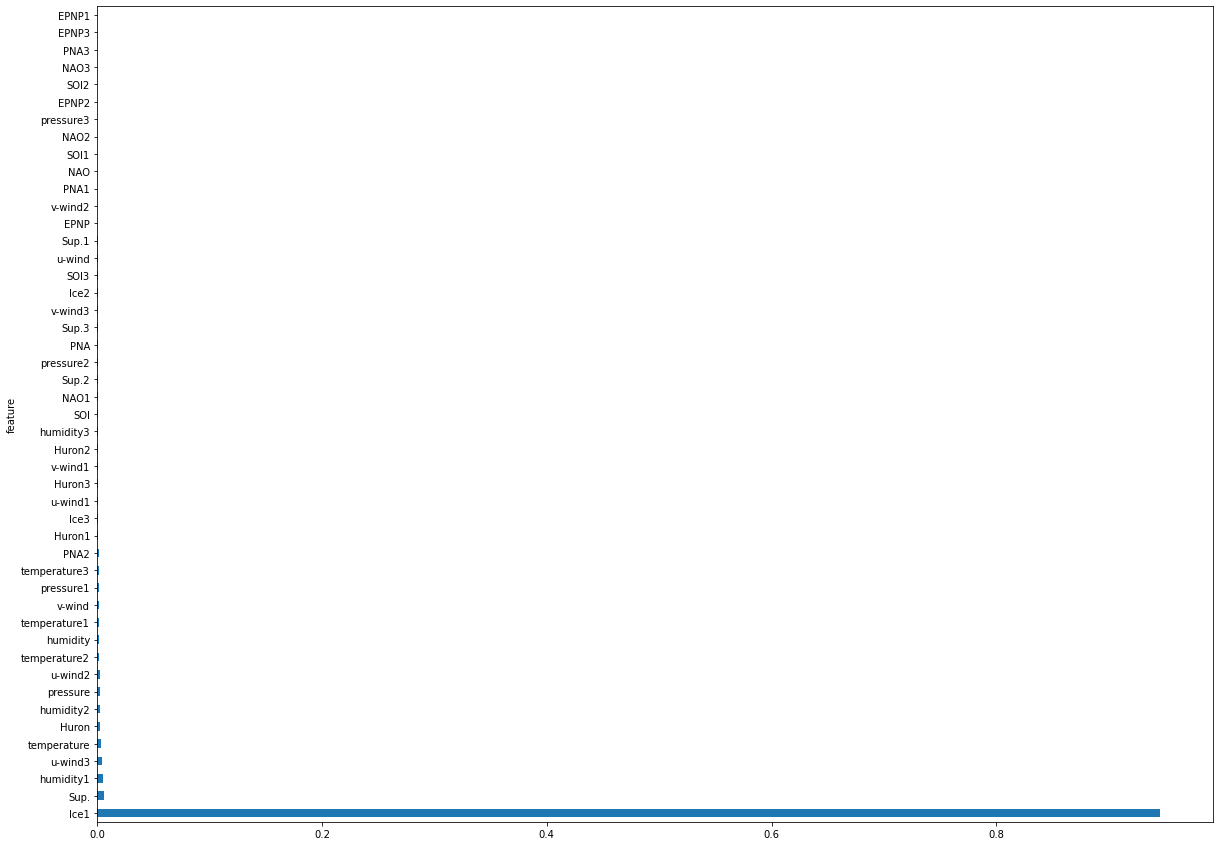

In [45]:
# Calculating variable importance as per the XGBoost model WITH ICE lags

var_importance = pd.DataFrame(xgb_grid.best_estimator_.feature_importances_)
features = pd.DataFrame(X_test.columns)
df_var_imp = pd.concat([features, var_importance], axis = 1)
df_var_imp.columns = ['feature', 'importance']
df_var_imp = df_var_imp.sort_values(by = ['importance'], ascending = False)
df_var_imp = df_var_imp.set_index(['feature'])

# Displaying the variable importance

%matplotlib inline
fig, ax = plt.subplots(figsize=(20, 15))
#plt.figure(figsize=(10,10))
df_var_imp['importance'].plot(kind = 'barh')

<ipython-input-46-d76c8be97a10>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['Ice'] = y_train
<ipython-input-46-d76c8be97a10>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['Ice_pred'] = y_train_pred


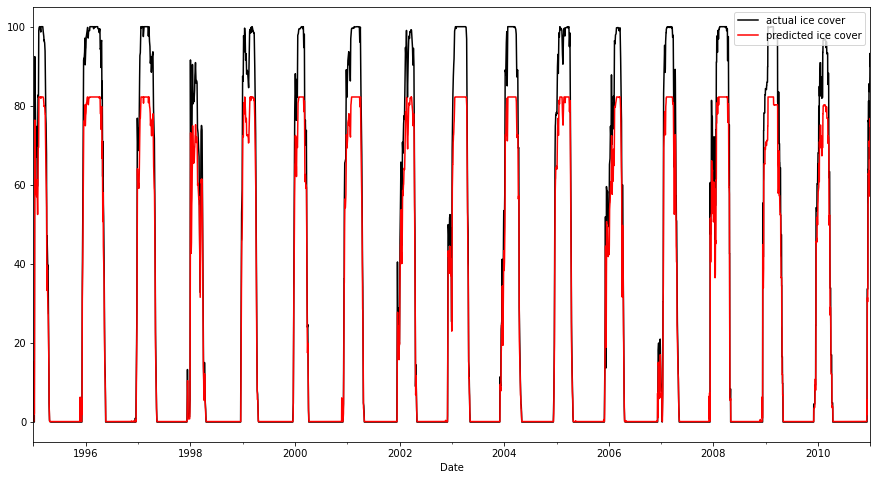

In [46]:
# Overlaying the training predictions on top of training data

X_train['Ice'] = y_train
X_train['Ice_pred'] = y_train_pred

plt.figure(figsize=(15,8))
X_train['Ice'].plot(label = 'actual ice cover', color='black')
X_train['Ice_pred'].plot(label = 'predicted ice cover', color = 'red')
plt.legend(loc="upper right")

<ipython-input-47-7a88c8d2ca6b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_valid['Ice'] = y_valid
<ipython-input-47-7a88c8d2ca6b>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_valid['Ice_pred'] = y_valid_pred


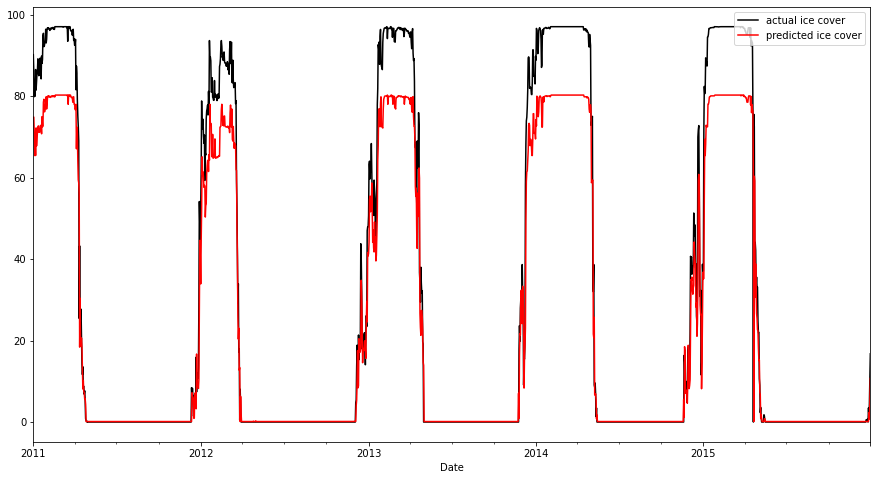

In [47]:
# Overlaying the training predictions on top of validation data

X_valid['Ice'] = y_valid
X_valid['Ice_pred'] = y_valid_pred

plt.figure(figsize=(15,8))
X_valid['Ice'].plot(label = 'actual ice cover', color='black')
X_valid['Ice_pred'].plot(label = 'predicted ice cover', color = 'red')
plt.legend(loc="upper right")

<ipython-input-48-ecf8eb0d0521>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['Ice'] = y_test
<ipython-input-48-ecf8eb0d0521>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['Ice_pred'] = y_test_pred


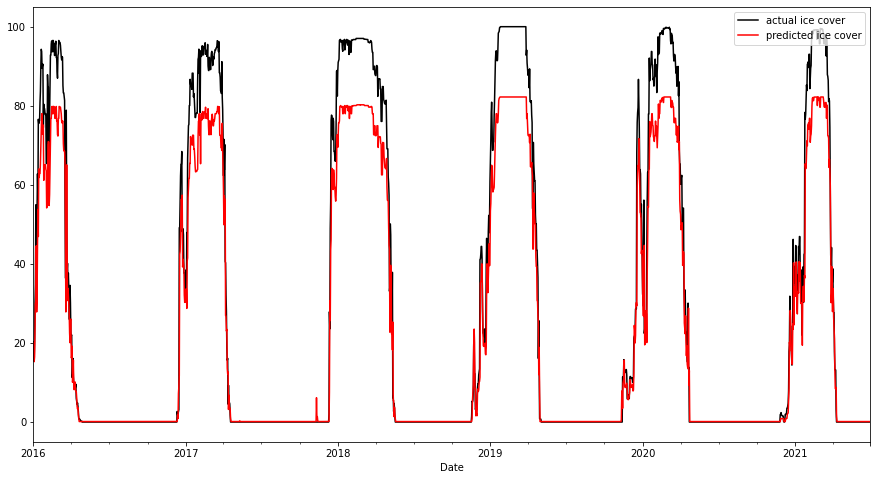

In [48]:
# Overlaying the training predictions on top of validation data

X_test['Ice'] = y_test
X_test['Ice_pred'] = y_test_pred

plt.figure(figsize=(15,8))
X_test['Ice'].plot(label = 'actual ice cover', color='black')
X_test['Ice_pred'].plot(label = 'predicted ice cover', color='red')
plt.legend(loc="upper right")

In [49]:
### XGBoost model to forecast the ice for the next 7 days. Here we select 2019-02-01 as the split date

split_date = '2021-02-01'

df_data_train = df_data.loc[df_data.index < split_date].copy()
df_data_test = df_data.loc[df_data.index == split_date].copy()

X_train = df_data_train.drop(['Ice'], axis = 1)
X_test = df_data_test.drop(['Ice'], axis = 1)
y_train = df_data_train['Ice']
y_test = df_data_test['Ice']

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

xgb1 = xgb.XGBRegressor()
parameters = {'objective':['reg:squarederror'],
              'learning_rate': [0.005],
              'max_depth': [4],
              'subsample': [0.8],
              'colsample_bytree': [1.0],
              'n_estimators': [350]}

tscv = TimeSeriesSplit(n_splits=5)

xgb_grid = GridSearchCV(xgb1,
                        parameters,
                        n_jobs = -1,
                        cv = tscv,
                        verbose=True)

xgb_grid.fit(X_train, y_train)

print(xgb_grid.best_score_)
print(xgb_grid.best_params_)

(9528, 47) (9528,)
(1, 47) (1,)
Fitting 5 folds for each of 1 candidates, totalling 5 fits
0.9487987442994568
{'colsample_bytree': 1.0, 'learning_rate': 0.005, 'max_depth': 4, 'n_estimators': 350, 'objective': 'reg:squarederror', 'subsample': 0.8}


In [50]:
### Predict ice cover on the day of the test data

y_test_pred = xgb_grid.predict(X_test)

y_test_pred

array([74.660706], dtype=float32)

In [51]:
### Actual ice cover on the day of the test data

y_test

Date
2021-02-01    91.106271
Name: Ice, dtype: float64

In [52]:
## calculating the mean absolute error

print(mean_absolute_error(y_test, y_test_pred))

16.445565548458617


In [53]:
######### Using the predicted value on any date as ground truth and then forecast for next 7 days #################

from datetime import datetime, timedelta

for i in range(1, 8):
    X_test['Ice3'] = X_test['Ice2']
    X_test['Ice2'] = X_test['Ice1']
    X_test['Ice1'] = y_test_pred
    
    res = (datetime.strptime(split_date, '%Y-%m-%d') + timedelta(days=i)).strftime('%Y-%m-%d')
    
    df_data_test = df_data.loc[df_data.index == res].copy()
    
    y_test = df_data_test['Ice']
    
    y_test_pred = xgb_grid.predict(X_test)
    
    print(res, y_test, y_test_pred)

2021-02-02 Date
2021-02-02    89.67481
Name: Ice, dtype: float64 [60.270145]
2021-02-03 Date
2021-02-03    93.026478
Name: Ice, dtype: float64 [52.882393]
2021-02-04 Date
2021-02-04    93.026478
Name: Ice, dtype: float64 [47.132183]
2021-02-05 Date
2021-02-05    84.3233
Name: Ice, dtype: float64 [40.96953]
2021-02-06 Date
2021-02-06    87.133699
Name: Ice, dtype: float64 [35.177723]
2021-02-07 Date
2021-02-07    89.512511
Name: Ice, dtype: float64 [34.58035]
2021-02-08 Date
2021-02-08    90.16137
Name: Ice, dtype: float64 [34.528133]


In [54]:
print(mean_absolute_error(y_test, y_test_pred))

55.63323696239574


##### After trying out different parameters , this is the optimal run 

In [55]:
X = df_data.drop(['Ice'], axis = 1) ####### This is to include ice lags
y = df_data['Ice']
X_train = X['1995-01-01':'2010-12-31']
X_valid = X['2011-01-01':'2015-12-31']
y_train = y['1995-01-01':'2010-12-31']
y_valid = y['2011-01-01':'2015-12-31']
X_test = X['2016-01-01':'2021-06-30']
y_test = y['2016-01-01':'2021-06-30']

In [56]:
# Running the XGBoost regressor with a wide range of hyper parameters and timeseries split
import time
t0 = time.time()

xgb1 = xgb.XGBRegressor()
parameters = {'objective' : ['reg:squarederror'],
              #'objective':['reg:tweedie'],
              'booster': ['gbtree', 'gblinear'],
              'early_stopping_rounds' : [20],
              'learning_rate': [0.005],
              'max_depth': [3],
              'subsample': [0.5, 0.6, 0.7],
              'colsample_bytree': [0.5, 0.6],
              'n_estimators': [1500],
              'eval_metric' : ['rmse'],
              'eval_set' : [[X_valid, y_valid]]}

tscv = TimeSeriesSplit(n_splits=10)

xgb_grid = GridSearchCV(xgb1,
                        parameters,
                        n_jobs = -1,
                        cv = tscv,
                        verbose=True)

xgb_grid.fit(X_train, y_train)

tF = time.time()

print(xgb_grid.best_score_)
print(xgb_grid.best_params_)

print('Time to train = %.2f seconds' % (tF - t0))

Fitting 10 folds for each of 12 candidates, totalling 120 fits
[09:26:45] WARNING: ..\src\learner.cc:541: 
Parameters: { early_stopping_rounds, eval_set } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


0.9947098489054376
{'booster': 'gbtree', 'colsample_bytree': 0.6, 'early_stopping_rounds': 20, 'eval_metric': 'rmse', 'eval_set': [                 Ice1       Ice2       Ice3    u-wind    v-wind  pressure  \
Date                                                                        
2011-01-01  90.160346  89.930617  93.241438  0.494847  0.702764  0.300207   
2011-01-02  90.160346  90.160346  89.930617  0.761438  0.670542  0.419040   
2011-01-03  85.904482  90.160346  90.160346  0.656702  0.591091  0.508692   
2011-01-04  79.836571  85.904482  90.160346  0.519295  0.520480  0.421

In [57]:
# Predicting on the Training data and calculating the mean absolute error

y_train_pred = xgb_grid.predict(X_train)

print(mean_absolute_error(y_train, y_train_pred))
print(math.sqrt(mean_squared_error(y_train, y_train_pred)))

0.8233428477513919
2.0682420160765833


In [58]:
# Predicting on the Validation data and calculating the mean absolute error

y_valid_pred = xgb_grid.predict(X_valid)

print(mean_absolute_error(y_valid, y_valid_pred))
print(math.sqrt(mean_squared_error(y_valid, y_valid_pred)))

1.3405807415717583
4.098970066527247


In [59]:
# Predicting on the test data and calculating the mean absolute error

y_test_pred = xgb_grid.predict(X_test)

print(mean_absolute_error(y_test, y_test_pred))
print(math.sqrt(mean_squared_error(y_test, y_test_pred)))

1.5916996995074646
3.876240320471173


<AxesSubplot:ylabel='feature'>

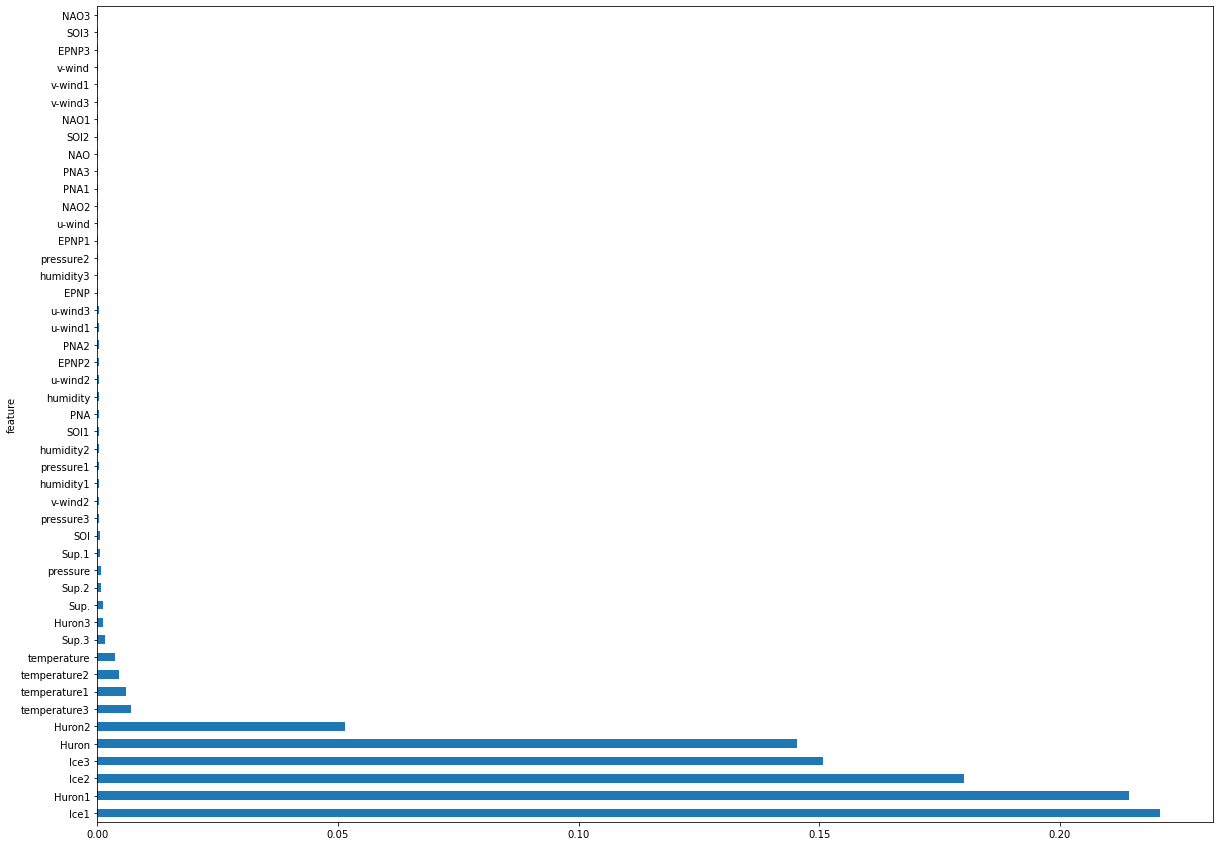

In [60]:
# Calculating variable importance as per the XGBoost model.

var_importance = pd.DataFrame(xgb_grid.best_estimator_.feature_importances_)
features = pd.DataFrame(X_test.columns)
df_var_imp = pd.concat([features, var_importance], axis = 1)
df_var_imp.columns = ['feature', 'importance']
df_var_imp = df_var_imp.sort_values(by = ['importance'], ascending = False)
df_var_imp = df_var_imp.set_index(['feature'])

# Displaying the variable importance

%matplotlib inline
fig, ax = plt.subplots(figsize=(20, 15))
#plt.figure(figsize=(10,10))
df_var_imp['importance'].plot(kind = 'barh')

<ipython-input-61-785c215a319c>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['Ice'] = y_train
<ipython-input-61-785c215a319c>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['Ice_pred'] = y_train_pred


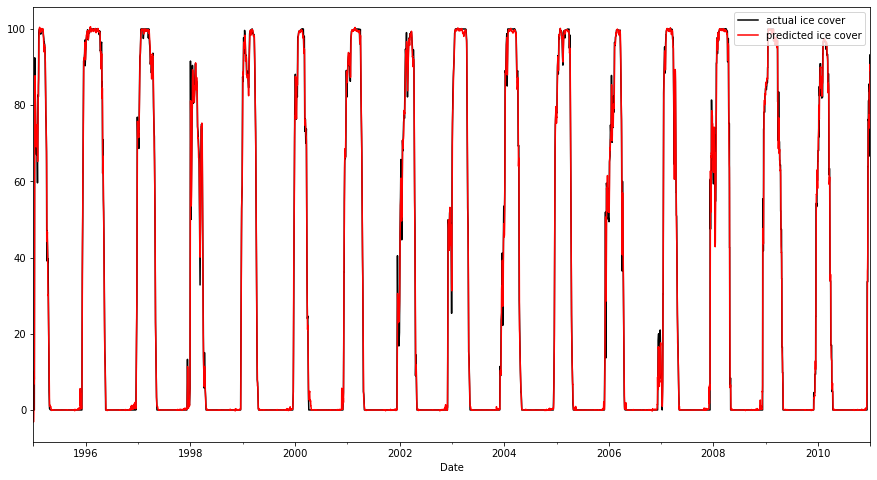

In [61]:
# Overlaying the training predictions on top of training data

X_train['Ice'] = y_train
X_train['Ice_pred'] = y_train_pred

plt.figure(figsize=(15,8))
X_train['Ice'].plot(label = 'actual ice cover', color = 'black')
X_train['Ice_pred'].plot(label = 'predicted ice cover', color = 'red')
plt.legend(loc="upper right")

<ipython-input-62-03a5112f9934>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_valid['Ice'] = y_valid
<ipython-input-62-03a5112f9934>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_valid['Ice_pred'] = y_valid_pred


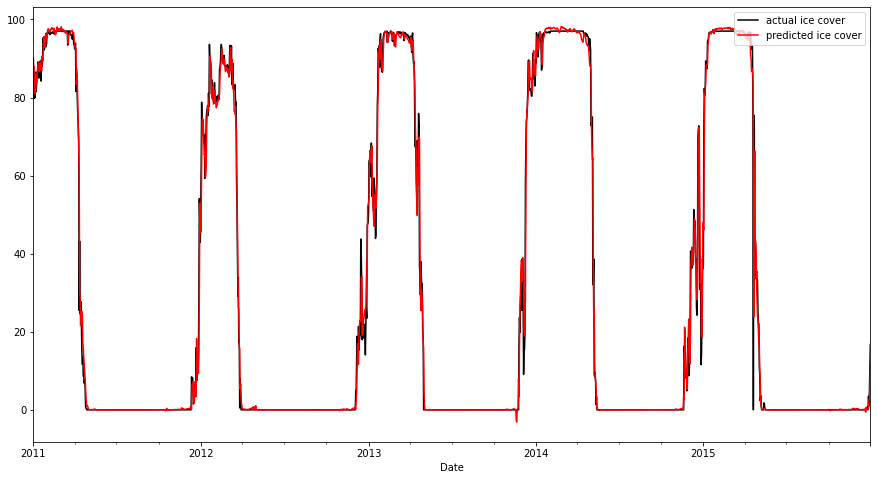

In [62]:
# Overlaying the training predictions on top of validation data

X_valid['Ice'] = y_valid
X_valid['Ice_pred'] = y_valid_pred

plt.figure(figsize=(15,8))
X_valid['Ice'].plot(label = 'actual ice cover', color = 'black')
X_valid['Ice_pred'].plot(label = 'predicted ice cover', color = 'red')
plt.legend(loc="upper right")

<ipython-input-63-57b7eda339b9>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['Ice'] = y_test
<ipython-input-63-57b7eda339b9>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['Ice_pred'] = y_test_pred


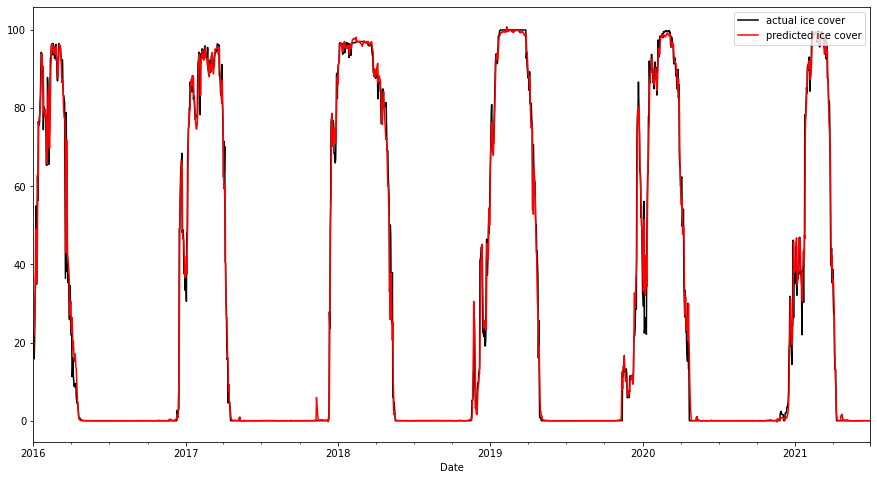

In [63]:
# Overlaying the training predictions on top of validation data

X_test['Ice'] = y_test
X_test['Ice_pred'] = y_test_pred

plt.figure(figsize=(15,8))
X_test['Ice'].plot(label = 'actual ice cover', color = 'black')
X_test['Ice_pred'].plot(label = 'predicted ice cover', color = 'red')
plt.legend(loc="upper right")

In [64]:
df_data.columns

Index(['Ice', 'Ice1', 'Ice2', 'Ice3', 'u-wind', 'v-wind', 'pressure',
       'humidity', 'temperature', 'u-wind1', 'v-wind1', 'pressure1',
       'humidity1', 'temperature1', 'u-wind2', 'v-wind2', 'pressure2',
       'humidity2', 'temperature2', 'u-wind3', 'v-wind3', 'pressure3',
       'humidity3', 'temperature3', 'Sup.', 'Huron', 'Sup.1', 'Huron1',
       'Sup.2', 'Huron2', 'Sup.3', 'Huron3', 'NAO', 'PNA', 'EPNP', 'SOI',
       'NAO1', 'PNA1', 'EPNP1', 'SOI1', 'NAO2', 'PNA2', 'EPNP2', 'SOI2',
       'NAO3', 'PNA3', 'EPNP3', 'SOI3'],
      dtype='object')

In [65]:
### XGBoost model to forecast the ice for the next 7 days. Here we select 2019-02-01 as the split date

split_date = '2021-02-01'

df_data_train = df_data.loc[df_data.index < split_date].copy()
df_data_test = df_data.loc[df_data.index == split_date].copy()

X_train = df_data_train.drop(['Ice'], axis = 1)
X_test = df_data_test.drop(['Ice'], axis = 1)
y_train = df_data_train['Ice']
y_test = df_data_test['Ice']

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

xgb1 = xgb.XGBRegressor()
parameters = {'objective' : ['reg:squarederror'],
              #'objective':['reg:tweedie'],
              'booster': ['gbtree', 'gblinear'],
              'early_stopping_rounds' : [20],
              'learning_rate': [0.005],
              'max_depth': [3],
              'subsample': [0.5],
              'colsample_bytree': [0.5],
              'n_estimators': [1500],
              'eval_metric' : ['rmse'],
              'eval_set' : [[X_valid, y_valid]]}

tscv = TimeSeriesSplit(n_splits=10)

xgb_grid = GridSearchCV(xgb1,
                        parameters,
                        n_jobs = -1,
                        cv = tscv,
                        verbose=True)

xgb_grid.fit(X_train, y_train)

print(xgb_grid.best_score_)
print(xgb_grid.best_params_)

(9528, 47) (9528,)
(1, 47) (1,)
Fitting 10 folds for each of 2 candidates, totalling 20 fits
[09:30:51] WARNING: ..\src\learner.cc:541: 
Parameters: { early_stopping_rounds, eval_set } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


0.9918888760998128
{'booster': 'gbtree', 'colsample_bytree': 0.5, 'early_stopping_rounds': 20, 'eval_metric': 'rmse', 'eval_set': [                 Ice1       Ice2       Ice3    u-wind    v-wind  pressure  \
Date                                                                        
2011-01-01  90.160346  89.930617  93.241438  0.494847  0.702764  0.300207   
2011-01-02  90.160346  90.160346  89.930617  0.761438  0.670542  0.419040   
2011-01-03  85.904482  90.160346  90.160346  0.656702  0.591091  0.508692   
2011-01-04  79.836571  85.904482  90.160

In [66]:
### Predict ice cover on the day of the test data

y_test_pred = xgb_grid.predict(X_test)

y_test_pred

array([89.485504], dtype=float32)

In [67]:
### Actual ice cover on the day of the test data

y_test

Date
2021-02-01    91.106271
Name: Ice, dtype: float64

In [68]:
## calculating the mean absolute error

print(mean_absolute_error(y_test, y_test_pred))

1.6207669644742424


In [69]:
######### Using the predicted value on any date as ground truth and then forecast for next 5 days #################

from datetime import datetime, timedelta

for i in range(1, 8):
    X_test['Ice3'] = X_test['Ice2']
    X_test['Ice2'] = X_test['Ice1']
    X_test['Ice1'] = y_test_pred
    
    res = (datetime.strptime(split_date, '%Y-%m-%d') + timedelta(days=i)).strftime('%Y-%m-%d')
    
    df_data_test = df_data.loc[df_data.index == res].copy()
    
    y_test = df_data_test['Ice']
    
    y_test_pred = xgb_grid.predict(X_test)
    
    print(res, y_test, y_test_pred)

2021-02-02 Date
2021-02-02    89.67481
Name: Ice, dtype: float64 [89.01145]
2021-02-03 Date
2021-02-03    93.026478
Name: Ice, dtype: float64 [88.56412]
2021-02-04 Date
2021-02-04    93.026478
Name: Ice, dtype: float64 [88.13323]
2021-02-05 Date
2021-02-05    84.3233
Name: Ice, dtype: float64 [88.1195]
2021-02-06 Date
2021-02-06    87.133699
Name: Ice, dtype: float64 [88.08629]
2021-02-07 Date
2021-02-07    89.512511
Name: Ice, dtype: float64 [88.08725]
2021-02-08 Date
2021-02-08    90.16137
Name: Ice, dtype: float64 [88.08725]


In [70]:
print(mean_absolute_error(y_test, y_test_pred))

2.0741205988703513


In [71]:
X_test

,Ice1,Ice2,Ice3,u-wind,v-wind,pressure,humidity,temperature,u-wind1,v-wind1,...,EPNP1,SOI1,NAO2,PNA2,EPNP2,SOI2,NAO3,PNA3,EPNP3,SOI3
Date,,,,,,,,,,,,,,,,,,,,,
2021-02-01,88.08725,88.086288,88.119499,0.400977,0.42933,0.666745,0.18087,0.327677,0.271037,0.515908,...,0.315966,0.833333,0.361888,0.54646,0.315966,0.833333,0.361888,0.54646,0.315966,0.833333


### Using Sherpa library for Hyperparameter Optimization

In [72]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
import time
import sherpa
import sherpa.algorithms.bayesian_optimization as bayesian_optimization

parameters = [sherpa.Discrete('n_estimators', [2, 50]),
sherpa.Choice('criterion', ['gini', 'entropy']),
sherpa.Continuous('max_features', [0.1, 0.9])]

algorithm = bayesian_optimization.GPyOpt(max_concurrent=1,
model_type='GP_MCMC',
acquisition_type='EI_MCMC',
max_num_trials=100)

#X, y = load_breast_cancer(return_X_y=True)
X = df_data.drop(['Ice'], axis = 1) ####### This is to include ice lags
y = df_data['Ice']
study = sherpa.Study(parameters=parameters,
algorithm=algorithm,
disable_dashboard=True,
lower_is_better=False)

for trial in study:
    print("Trial ", trial.id, " with parameters ", trial.parameters)
    clf = RandomForestClassifier(criterion=trial.parameters['criterion'],
    max_features=trial.parameters['max_features'],
    n_estimators=trial.parameters['n_estimators'],
    random_state=0)
    scores = cross_val_score(clf, X, y, cv=5)
    print("Score: ", scores.mean())
    study.add_observation(trial, iteration=1, objective=scores.mean())
    study.finalize(trial)
    print(study.get_best_result())

study.save(".")

Trial  1  with parameters  {'n_estimators': 4, 'criterion': 'entropy', 'max_features': 0.23927978340701747}
Score:  nan


KeyError: nan

Checking for Stationarity of the series ice_data1, surface_temp1, climate_ind_d1, meterology1

In [ ]:
meterology1.head()

In [ ]:
meterology1.plot(subplots=True, figsize=(15,6), color='black')

In [ ]:
#Vizualising temperature at granulaity - month
ax = meterology1.loc['2020-01-01':'2020-12-31', 'temperature'].plot(marker='o', linestyle='-',color='black')
ax.set_ylabel('temperature');

In [ ]:
meterology1.hist(color='black')

In [ ]:
surface_temp1.plot(subplots=True, figsize=(15,6), color='black')

In [ ]:
surface_temp1.hist(color='black')

In [ ]:
climate_ind_d1.plot(subplots=True, figsize=(15,6), color='black')

In [ ]:
climate_ind_d1.hist(color='black')

In [ ]:
ice_data1.plot(subplots=True, figsize=(15,6), color='black')

In [ ]:
ice_data1.hist(color='black')

In [ ]:
from pandas import read_csv
from statsmodels.tsa.stattools import adfuller
X = meterology1.values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

In [ ]:
# Converting last column i.e 'November' to Series
temp1 = meterology1.i[:,3]
  
print("\nLast column as a Series:\n")
print(temp1)
  
# Checking type
print(type(temp1))

In [ ]:
#df_dtlm4_clim

In [ ]:
#df_dtlm4_clim.index

In [ ]:
#print(df_dtlm4_d.shape)
#print(df_dtlm4_clim.shape)

In [ ]:
#Checking the mising data in the dataframe
#"True" indicates missing value and "False" indicates no missing values
#missing_data = df_dtlm4.isnull()
#missing_data.head()

In [ ]:
#counting the missing values in all features.
#True indicates missing values
#for column in missing_data.columns.values.tolist():
#    print(column)
#   print (missing_data[column].value_counts())
#    print("") 

In [ ]:
# Dropping the features with mostly missing values 

#df_dtlm4_d = df_dtlm4_d.drop(['WVHT', 'DPD', 'APD', 'MWD', 'WTMP', 'DEWP', 'VIS', 'TIDE'], axis = 1)

In [ ]:
# Reading the Ice data using glob package into a list of dataframes
# Raw data has Ice cover values for the 4 stations and mean ice coverage from years 2004 to 2020
# the output is a list of dataframes

#filenames = glob('C:/Users/santh/OneDrive/Desktop/XGBoost/Ice_data/timeseries*.xlsx')
#dataframes_ice = [pd.read_excel(f, index_col = 0, header = 0) for f in filenames]

In [ ]:
#Concatenating the dataframes into a single dataframe
#df_ice_dtlm4 = pd.concat(dataframes_ice, sort = False)
#df_ice_dtlm4.head()

In [ ]:
#df_ice_dtlm4.tail()

In [ ]:
#index = df_ice_dtlm4.index

#for i in index:
#    print(i)

In [ ]:
#df_ice_dtlm4.reset_index(inplace=True)
#df_ice_dtlm4.head(5)

In [ ]:
#start_date = "2007-01-01"
#end_date = "2020-04-22"

after_start_date = df_ice_dtlm4["date"] >= start_date
before_end_date = df_ice_dtlm4["date"] <= end_date
between_two_dates = after_start_date & before_end_date
filtered_dates = df_ice_dtlm4.loc[between_two_dates]

print(filtered_dates)

In [ ]:
df_ice_dtlm4.loc[:,["DTLM","date"]]

In [ ]:
df_ice_dtlm4.describe()

In [ ]:
# Retaining just the Ice cover of the station DTLM4 from the ice dataframe i.e. retaining only "DTLM" column

df_ice_dtlm4 = df_ice_dtlm4.drop(['mean_icecoverage', 'LTRM', 'SWPM', 'WNEM'], axis = 1)

In [ ]:
# Merging the weather station dataframe with the ice dataframe

df_merge = pd.merge(df_dtlm4_d, df_ice_dtlm4, how = 'inner', left_index = True, right_index = True)
df_merge.head()

In [ ]:
df_merge.tail()

In [ ]:
#In addition to the numeric values, WDIR - wind direction has the direction labels as well. i.e. North-West, South etc.
#Analysing these directions here

def label_wdir(data):
    if data['WDIR'] == 0.0 :
        return 'North'
    if data['WDIR'] == 90.0 :
        return 'East'
    if data['WDIR'] == 180.0 :
        return 'South'
    if data['WDIR'] == 270.0 :
        return 'West'
    if 0 < data['WDIR'] < 90 :
        return 'North-East'
    if 90 < data['WDIR'] < 180 :
        return 'South-East'
    if 180 < data['WDIR'] < 270 :
        return 'South-West'
    if 270 < data['WDIR'] < 360 :
        return 'North-West'
    return 'Unknown'
df_merge['Direction'] = df_merge.apply(lambda data: label_wdir(data), axis = 1)

In [ ]:
df_merge['Direction'].value_counts()

In [ ]:
df_merge = df_merge[df_merge['Direction'] != 'Unknown']

In [ ]:
#Breaking WDIR into degrees in specific directions 

def wind_magnitude(data) :
    if 90 < data['WDIR'] < 180:
        return data['WDIR']-90
    if 180 < data['WDIR'] < 270:
        return data['WDIR']-180
    if 270 < data['WDIR'] < 360:
        return data['WDIR']-270
    return data['WDIR']

df_merge['WDIR_New'] = df_merge.apply(lambda data: wind_magnitude(data), axis = 1)

df_merge['WDIR_New'].describe()

In [ ]:
df_merge = pd.get_dummies(df_merge, prefix=['Wind'], columns = ['Direction'], drop_first=True)
df_merge.head()

In [ ]:
df_merge = df_merge.drop(['WDIR'], axis = 1)
df_merge.head()

In [ ]:
df_merge.shape

#### 3. XGBoost Model development - DTLM4

In [ ]:
######### Creating lags and moving averages for Ice cover (DTLM) and Air Temperature(ATMP) features ################

for i in range(1,6):
    col = 'ATMP_lag_' + str(i)
    df_merge[col] = df_merge['ATMP'].shift(i)

for i in range(1,6):
    col = 'Ice_lag_' + str(i)
    df_merge[col] = df_merge['DTLM'].shift(i)

for i in range(3,6):
    col = 'ATMP_RM_' + str(i)
    df_merge[col] = df_merge['ATMP'].rolling(i).mean()
    df_merge[col] = df_merge[col].shift(1)

for i in range(3,6):
    col = 'Ice_RM_' + str(i)
    df_merge[col] = df_merge['DTLM'].rolling(i).mean()
    df_merge[col] = df_merge[col].shift(1)

df_merge.head()

In [ ]:
df_merge.tail()

In [ ]:
df_merge['PRES'].describe()

In [ ]:
# For Pressure feature, creating z-score as an additional feature
cols = ['PRES']

for col in cols:
    col_zscore = col + '_zscore'
    df_merge[col_zscore] = (df_merge[col] - df_merge[col].mean())/df_merge[col].std(ddof=0)

df_merge.head()

In [ ]:
df_merge[['WSPD', 'GST', 'PRES', 'ATMP', 'DTLM', 'PRES_zscore']].head()

In [ ]:
df_merge_ice_on_off = df_merge[['WSPD', 'GST', 'PRES', 'ATMP', 'DTLM']]
df_merge_ice_on_off.head(10)

In [ ]:
df_merge_ice_on_off.tail()

In [ ]:
df_merge_ice_on_off['month'] = pd.DatetimeIndex(df_merge_ice_on_off.index).month
df_merge_ice_on_off['year'] = pd.DatetimeIndex(df_merge_ice_on_off.index).year
df_merge_ice_on_off['day'] = pd.DatetimeIndex(df_merge_ice_on_off.index).day

df_merge_ice_on_off['Ice_RM_3'] = df_merge_ice_on_off['DTLM'].rolling(3).mean()

df_ice_off = df_merge_ice_on_off[(df_merge_ice_on_off['month'] <= 7) & (df_merge_ice_on_off['month'] > 1)]
df_ice_on = df_merge_ice_on_off[(df_merge_ice_on_off['month'] > 7)]

df_ice_on['Ice_on_off'] = np.where(df_ice_on['Ice_RM_3'] >= 10, 'Ice_on_date', 'Normal')
df_ice_on = df_ice_on[df_ice_on['Ice_on_off'] != 'Normal']
df_ice_on = df_ice_on.drop_duplicates(subset=['year', 'Ice_on_off'], keep='first')

df_ice_off['Ice_on_off'] = np.where((df_ice_off['month'] > 3) & (df_ice_off['Ice_RM_3'] <= 10), 'Ice_off_date', 'Normal')
df_ice_off = df_ice_off[df_ice_off['Ice_on_off'] != 'Normal']
df_ice_off = df_ice_off.drop_duplicates(subset=['year', 'Ice_on_off'], keep='first')

df_merge_ice_on_off = pd.concat([df_ice_off, df_ice_on], axis = 0)
df_merge_ice_on_off = df_merge_ice_on_off.reset_index()
df_merge_ice_on_off = df_merge_ice_on_off.sort_values(by = 'index')
df_merge_ice_on_off = df_merge_ice_on_off.set_index('index')

df_merge_ice_on_off = df_merge_ice_on_off[df_merge_ice_on_off['Ice_on_off'] != 'Normal']

df_merge_ice_on_off

In [ ]:
df_ice = pd.concat(dataframes_ice, sort = False)
df_ice = df_ice.reset_index()
df_ice.head()

In [ ]:
df_ice.tail()

In [ ]:
# Importing packages for XGBoost and K-fold Gridsearch
# In Anacomnda command propmpt execute the command conda install -c anaconda py-xgboost
from xgboost import XGBRegressor
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

In [ ]:
df_merge.head()

In [ ]:
df_merge.tail()

In [ ]:
# Separating the Independent/predictor and dependent/response(Ice cover) variables

X = df_merge.drop(['DTLM'], axis = 1)
y = df_merge['DTLM']

# Creating training and validation data for model building

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)
#print(X_train.shape, y_train.shape)
#print(X_test.shape, y_test.shape)

In [ ]:
y

In [ ]:
X_train = X['2007-01-01':'2015-12-31']
X_test = X['2016-01-01':'2019-12-31']
y_train = y['2007-01-01':'2015-12-31']
y_test = y['2016-01-01':'2019-12-31']

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

In [ ]:
X_valid = X['2020-01-01':'2020-12-31']
y_valid = y['2020-01-01':'2020-12-31']

In [ ]:
X_valid

In [ ]:
# Running the XGBoost regressor with a wide range of hyper parameters and 5 CV timeseries splits

t0 = time.time()

xgb1 = xgb.XGBRegressor()
parameters = {'objective':['reg:squarederror'],
              'learning_rate': [0.001, 0.01, 0.05, 0.1],
              'max_depth': [3, 4, 5],
              'subsample': [0.7, 0.8],
              'colsample_bytree': [1.0],
              'n_estimators': [100, 200]}

tscv = TimeSeriesSplit(n_splits=5)

xgb_grid = GridSearchCV(xgb1,
                        parameters,
                        n_jobs = -1,
                        cv = tscv,
                        verbose=True)

xgb_grid.fit(X_train, y_train)

tF = time.time()

print(xgb_grid.best_score_)
print(xgb_grid.best_params_)

print('Time to train = %.2f seconds' % (tF - t0))

In [ ]:
# Predicting on the training data and calculating the mean absolute error

y_train_pred = xgb_grid.predict(X_train)

print(mean_absolute_error(y_train, y_train_pred))

In [ ]:
# Predicting on the test data and calculating the mean absolute error

y_test_pred = xgb_grid.predict(X_test)

print(mean_absolute_error(y_test, y_test_pred))

In [ ]:
# Predicting on the validation data and calculating the mean absolute error

y_valid_pred = xgb_grid.predict(X_valid)

print(mean_absolute_error(y_valid, y_valid_pred))

In [ ]:
df_train = X_train.copy()
df_train['y_train'] = y_train
df_train['y_train_pred'] = y_train_pred

df_test = X_test.copy()
df_test['y_test'] = y_test
df_test['y_test_pred'] = y_test_pred

df_valid = X_valid.copy()
df_valid['y_valid'] = y_valid
df_valid['y_valid_pred'] = y_valid_pred

In [ ]:
df_test = df_test[['WSPD', 'GST', 'PRES', 'ATMP', 'y_test', 'y_test_pred']]
df_valid = df_valid[['WSPD', 'GST', 'PRES', 'ATMP', 'y_valid', 'y_valid_pred']]
df_train = df_train[['WSPD', 'GST', 'PRES', 'ATMP', 'y_train', 'y_train_pred']]

df_test.columns = ['WSPD', 'GST', 'PRES', 'ATMP', 'DTLM', 'DTLM_Pred']
df_valid.columns = ['WSPD', 'GST', 'PRES', 'ATMP', 'DTLM', 'DTLM_Pred']
df_train.columns = ['WSPD', 'GST', 'PRES', 'ATMP', 'DTLM', 'DTLM_Pred']


df_test['DTLM_Pred_RM_3'] = df_test['DTLM_Pred'].rolling(3).mean()
#df_test['DTLM_Pred_RM_3'] = df_test['DTLM_Pred_RM_3'].shift(1)

df_valid['DTLM_Pred_RM_3'] = df_valid['DTLM_Pred'].rolling(3).mean()

df_train['DTLM_Pred_RM_3'] = df_train['DTLM_Pred'].rolling(3).mean()
#df_train['DTLM_Pred_RM_3'] = df_train['DTLM_Pred_RM_3'].shift(1)

df_ml = pd.concat([df_train, df_test, df_valid], axis = 0)
df_ml.head()

In [ ]:
df_ml.tail()

In [ ]:
df_ml['month'] = pd.DatetimeIndex(df_ml.index).month
df_ml['year'] = pd.DatetimeIndex(df_ml.index).year
df_ml['day'] = pd.DatetimeIndex(df_ml.index).day

df_ice_off = df_ml[(df_ml['month'] <= 7) & (df_ml['month'] > 1)]
df_ice_on = df_ml[(df_ml['month'] > 7)]

df_ice_on['Ice_on_off'] = np.where(df_ice_on['DTLM_Pred_RM_3'] >= 10, 'Ice_on_date', 'Normal')
df_ice_on = df_ice_on[df_ice_on['Ice_on_off'] != 'Normal']
df_ice_on = df_ice_on.drop_duplicates(subset=['year', 'Ice_on_off'], keep='first')

df_ice_off['Ice_on_off'] = np.where((df_ice_off['month'] > 3) & (df_ice_off['DTLM_Pred_RM_3'] <= 10), 'Ice_off_date', 'Normal')
df_ice_off = df_ice_off[df_ice_off['Ice_on_off'] != 'Normal']
df_ice_off = df_ice_off.drop_duplicates(subset=['year', 'Ice_on_off'], keep='first')

df_ml = pd.concat([df_ice_off, df_ice_on], axis = 0)
df_ml = df_ml.reset_index()
df_ml = df_ml.sort_values(by = 'index')
df_ml = df_ml.set_index('index')

df_ml

In [ ]:
df_ice_off

In [ ]:
##################### Creating actual Ice duration dataframe #######################

df_merge_ice_on_off = df_merge_ice_on_off.reset_index()
df_merge_ice_on_off.rename(columns={'index':'Date'}, inplace = True)

df_ice_on = df_merge_ice_on_off[df_merge_ice_on_off['Ice_on_off'] == 'Ice_on_date']
df_ice_off = df_merge_ice_on_off[df_merge_ice_on_off['Ice_on_off'] == 'Ice_off_date']

df_ice_on.rename(columns={'Date':'Ice_on_date'}, inplace = True)
df_ice_off.rename(columns={'Date':'Ice_off_date'}, inplace = True)

df_ice_on = df_ice_on[['year', 'Ice_on_date']]
df_ice_off = df_ice_off[['year', 'Ice_off_date']]

df2 = {'year': 2015, 'Ice_on_date': '2015-12-15'}
df_ice_on = df_ice_on.append(df2, ignore_index = True)
df_ice_on['Ice_on_date'] = pd.to_datetime(df_ice_on['Ice_on_date'])
df_ice_on = df_ice_on.sort_values(by = ['year'])

df_actual_ice = df_ice_off.merge(df_ice_on, on = 'year', how = 'left')
df_actual_ice['Ice_off_date'] = pd.to_datetime(df_actual_ice['Ice_off_date'])
df_actual_ice['Ice_on_date'] = pd.to_datetime(df_actual_ice['Ice_on_date'])
df_actual_ice['duration'] = df_actual_ice['Ice_off_date'].shift(-1) - df_actual_ice['Ice_on_date']

##################### Creating predicted Ice duration dataframe #######################

df_ml = df_ml.reset_index()
df_ml.rename(columns={'index':'Date'}, inplace = True)

df_ice_on = df_ml[df_ml['Ice_on_off'] == 'Ice_on_date']
df_ice_off = df_ml[df_ml['Ice_on_off'] == 'Ice_off_date']

df_ice_on.rename(columns={'Date':'Ice_on_date'}, inplace = True)
df_ice_off.rename(columns={'Date':'Ice_off_date'}, inplace = True)

df_ice_on = df_ice_on[['year', 'Ice_on_date']]
df_ice_off = df_ice_off[['year', 'Ice_off_date']]

df2 = {'year': 2015, 'Ice_on_date': '2015-12-15'}
df_ice_on = df_ice_on.append(df2, ignore_index = True)
df_ice_on['Ice_on_date'] = pd.to_datetime(df_ice_on['Ice_on_date'])
df_ice_on = df_ice_on.sort_values(by = ['year'])

df_predicted_ice = df_ice_off.merge(df_ice_on, on = 'year', how = 'left')
df_predicted_ice['Ice_off_date'] = pd.to_datetime(df_predicted_ice['Ice_off_date'])
df_predicted_ice['Ice_on_date'] = pd.to_datetime(df_predicted_ice['Ice_on_date'])
df_predicted_ice['duration'] = df_predicted_ice['Ice_off_date'].shift(-1) - df_predicted_ice['Ice_on_date']
df_predicted_ice

In [ ]:
#to use in final merged code later on
df_icedur_pred_dtlm4 = df_predicted_ice

In [ ]:
#to use in final merged code later on
df_icedur_act_dtlm4 = df_actual_ice

In [ ]:
# Draw the Ice-on and Ice-off plots


df_original = df_actual_ice
df = df_predicted_ice

xValue_original = []
yValue_original = []
xValue = []
yValue = []
tick_spacing = 5

for i in range(1,len(df_original['year'])):
    if(int(df_original['Ice_off_date'][i].strftime("%m")) < 11):
        xValue_original.append(df_original['year'][i])
        xValue_original.append(df_original['year'][i])
    else:
        xValue_original.append(df_original['year'][i]+1)
        xValue_original.append(df_original['year'][i]+1)

for i in range(1,len(df['year'])):
    if(int(df['Ice_off_date'][i].strftime("%m")) < 11):
        xValue.append(df['year'][i])
        xValue.append(df['year'][i])
    else:
        xValue.append(df['year'][i]+1)
        xValue.append(df['year'][i]+1)
        
    
for i in range(0,(len(df_original['Ice_off_date'])-1)):
    if(int(df_original['Ice_on_date'][i].strftime("%m")) >= 11):
        start_date = datetime(int(df_original['Ice_on_date'][i].strftime("%Y")),11,1,0,0,0)
    yValue_original.append((df_original['Ice_on_date'][i]-start_date).days)
    yValue_original.append((df_original['Ice_off_date'][i+1]-start_date).days)

for i in range(0,(len(df['Ice_off_date'])-1)):
    if(int(df['Ice_on_date'][i].strftime("%m")) >= 11):
        start_date = datetime(int(df['Ice_on_date'][i].strftime("%Y")),11,1,0,0,0)
    else:
        start_date = datetime(int(df['Ice_on_date'][i].strftime("%Y"))-1,11,1,0,0,0)
    yValue.append((df['Ice_on_date'][i]-start_date).days)
    yValue.append((df['Ice_off_date'][i+1]-start_date).days)


      
plt.figure(figsize=(16,8))  

for i in range(0, int(len(xValue)/2)):

    plt.annotate(df['Ice_on_date'][i].strftime("%Y-%m-%d"),(xValue[2*i],yValue[2*i]), xytext=(xValue[2*i]+0.25,yValue[2*i] -2), fontsize=8)
#     plt.annotate(df['Ice_off_date'][i+1].strftime("%Y-%m-%d"),(xValue[2*i+1],yValue[2*i+1]), xytext=(xValue[2*i+1]-0.8,yValue[2*i+1]), fontsize=8)

    

# for i in range(0, int(len(xValue_original)/2)):
#     ice_on_point = plt.scatter(xValue_original[2*i], yValue_original[2*i], color = 'r', s=6. )
#     ice_off_point = plt.scatter(xValue_original[2*i+1], yValue_original[2*i+1], color = 'b', s=6.)
    
# for i in range(0, int(len(xValue)/2)):
#     ice_on_point = plt.scatter(xValue[2*i] + 0.3, yValue[2*i], color = 'y', s=6. )
#     ice_off_point = plt.scatter(xValue[2*i+1] + 0.3, yValue[2*i+1], color = 'g', s=6.)


# l2 = plt.legend([ice_on_point, ice_off_point], labels = ['Ice On Date', 'Ice Off Date'], bbox_to_anchor=(1.05, 0), loc=1, borderaxespad=0)            


    
for i in range(0, int(len(xValue_original)/2)):
    if(i==0):
        line1 = plt.plot([xValue_original[2*i], xValue_original[2*i+1]],[yValue_original[2*i], yValue_original[2*i+1]],  color ='k', label = 'Original')
        
    line1 = plt.plot([xValue_original[2*i], xValue_original[2*i+1]],[yValue_original[2*i], yValue_original[2*i+1]],  color ='k')

plt.legend()
    #     plt.annotate(df['Ice Duration'][i], ((xValue[2*i]+xValue[2*i+1])/2, (yValue[2*i]+yValue[2*i+1])/2), ((xValue[2*i]+xValue[2*i+1])/2+0.1, (yValue[2*i]+yValue[2*i+1])/2))
    
for j in range(0, int(len(xValue)/2)):
    if(j == 0):
        line2 = plt.plot([xValue[2*j] + 0.3, xValue[2*j+1]+0.3],[yValue[2*j], yValue[2*j+1]], label = 'predicted', color = 'r')
        
    line2 = plt.plot([xValue[2*j] + 0.3, xValue[2*j+1]+0.3],[yValue[2*j], yValue[2*j+1]], color = 'r')  

plt.legend(loc='upper right', fontsize = 12)
        
    
# plt.legend([line1, line2], labels=['Original', 'Predicted'], bbox_to_anchor=(1.05, 1), loc=1, borderaxespad=0)


# plt.gca().add_artist(l2)




plt.title('Ice Season Duration Original vs Predicted for station DTLM4' , fontsize=20)

# plt.axis('off')
plt.yticks([])


frame = plt.gca().axes.get_xaxis().set_visible(False)

plt.savefig('ice_duration_DTLM4.png')

In [ ]:
#df_ml.to_csv('predicted_ice_on_off.csv', index = True)

In [ ]:
# Calculating variable importance as per the XGBoost model.

var_importance = pd.DataFrame(xgb_grid.best_estimator_.feature_importances_)
features = pd.DataFrame(X_test.columns)
df_var_imp = pd.concat([features, var_importance], axis = 1)
df_var_imp.columns = ['feature', 'importance']
df_var_imp = df_var_imp.sort_values(by = ['importance'], ascending = False)
df_var_imp = df_var_imp.set_index(['feature'])

In [ ]:
# Displaying the variable importance

%matplotlib inline
fig, ax = plt.subplots(figsize=(20, 15))
#plt.figure(figsize=(10,10))
df_var_imp['importance'].plot(kind = 'barh')

In [ ]:
print(df_var_imp)

In [ ]:
# Overlaying the training predictions on top of training data

plt.figure(figsize=(15,8))
df_train['DTLM'].plot(label = 'actual ice cover')
df_train['DTLM_Pred'].plot(label = 'predicted ice cover')
plt.legend(loc="upper right")

In [ ]:
########################## Code for Baseline vs Actual vs Predicted Ice cover #######################

df_plot = pd.concat([df_train, df_test, df_valid], axis = 0)
df_plot = df_plot.drop(['WSPD', 'GST', 'PRES', 'ATMP', 'DTLM_Pred_RM_3'], axis = 1)
df_plot['year'] = df_plot.index.year
df_plot['month'] = df_plot.index.month
df_plot['day'] = df_plot.index.day

df_plot_2020 = df_plot[df_plot['year'] == 2020]
df_plot_rem = df_plot[df_plot['year'] <= 2019]

res = pd.DataFrame(df_plot_rem.groupby(['month', 'day'])['DTLM'].mean().reset_index())
res = res.rename(columns = {'DTLM': 'DTLM_Baseline'})
df_plot_2020_final = df_plot_2020.merge(res, on = ['month', 'day'], how = 'inner')
df_plot_2020_final.index = df_plot_2020.index

df_plot_2019 = df_plot[df_plot['year'] == 2019]
df_plot_rem = df_plot[df_plot['year'] <= 2018]

res = pd.DataFrame(df_plot_rem.groupby(['month', 'day'])['DTLM'].mean().reset_index())
res = res.rename(columns = {'DTLM': 'DTLM_Baseline'})
df_plot_2019_final = df_plot_2019.merge(res, on = ['month', 'day'], how = 'inner')
df_plot_2019_final.index = df_plot_2019.index

df_plot_2018 = df_plot[df_plot['year'] == 2018]
df_plot_rem = df_plot[df_plot['year'] <= 2017]

res = pd.DataFrame(df_plot_rem.groupby(['month', 'day'])['DTLM'].mean().reset_index())
res = res.rename(columns = {'DTLM': 'DTLM_Baseline'})
df_plot_2018_final = df_plot_2018.merge(res, on = ['month', 'day'], how = 'inner')
df_plot_2018_final.index = df_plot_2018.index

df_plot_final = pd.concat([df_plot_2018_final, df_plot_2019_final, df_plot_2020_final], axis = 0)
df_plot_final

In [ ]:
# Overlaying the 2018 and 2019 predictions and baseline on top of actual data

plt.figure(figsize=(15,8))
df_subset_2020 = df_plot_final.loc['2018-01-01':'2020-12-31']
df_subset = df_plot_final.loc['2018-01-01':'2019-12-31']
df_subset['DTLM'].plot(label = 'actual ice cover')
df_subset['DTLM_Pred'].plot(label = 'predicted ice cover')
df_subset['DTLM_Baseline'].plot(label = 'baseline ice cover')
plt.legend(loc="lower left")

In [ ]:
df_dtlm4_2018_2019 = df_subset_2020

In [ ]:
# Overlaying the 2018 and 2019 predictions on top of actual data

plt.figure(figsize=(15,8))
df_subset = df_plot_final.loc['2018-01-01':'2019-12-31']
df_subset['DTLM'].plot(label = 'actual ice cover')
df_subset['DTLM_Pred'].plot(label = 'predicted ice cover')
plt.legend(loc="lower left")

In [ ]:
# Overlaying January 2019 predictions on top of actual data for January 2019

plt.figure(figsize=(15,8))
df_subset = df_test.loc['2019-01-01':'2019-01-31']
df_subset['DTLM'].plot(label = 'actual ice cover')
df_subset['DTLM_Pred'].plot(label = 'predicted ice cover')
plt.legend(loc="upper left")

In [ ]:
### XGBoost model to forecast the ice for the next 14 days. Here we select 2019-02-01 as the split date

split_date = '2019-02-01'

df_merge_1 = df_merge[['DTLM', 'Ice_lag_1', 'Ice_RM_3', 'Ice_RM_4', 'Ice_RM_5',  
                      'ATMP_RM_4', 'ATMP_RM_3', 'ATMP_RM_5', 'Ice_lag_2', 'ATMP_lag_4', 'ATMP', 'Ice_lag_3','Ice_lag_4', 'Ice_lag_5']]

df_merge_train = df_merge_1.loc[df_merge.index < split_date].copy()
df_merge_test = df_merge_1.loc[df_merge.index == split_date].copy()

X_train = df_merge_train.drop(['DTLM'], axis = 1)
X_test = df_merge_test.drop(['DTLM'], axis = 1)
y_train = df_merge_train['DTLM']
y_test = df_merge_test['DTLM']

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

xgb1 = xgb.XGBRegressor()
parameters = {'objective':['reg:squarederror'],
              'learning_rate': [0.001, 0.01, 0.05, 0.1],
              'max_depth': [3],
              'subsample': [0.7, 0.8],
              'colsample_bytree': [1.0],
              'n_estimators': [100, 200]}

tscv = TimeSeriesSplit(n_splits=5)

xgb_grid = GridSearchCV(xgb1,
                        parameters,
                        n_jobs = -1,
                        cv = tscv,
                        verbose=True)

xgb_grid.fit(X_train, y_train)

print(xgb_grid.best_score_)
print(xgb_grid.best_params_)

In [ ]:
### Predict ice cover on the day of the test data

y_test_pred = xgb_grid.predict(X_test)

y_test_pred

In [ ]:
### Actual ice cover on the day of the test data

y_test

In [ ]:
## calculating the mean absolute error

print(mean_absolute_error(y_test, y_test_pred))

In [ ]:
X_test.columns

In [ ]:
######### Using the predicted value on any date as ground truth and forecasting for next 14 days #################

for i in range(1, 15):
    X_test['Ice_lag_5'] = X_test['Ice_lag_4']
    X_test['Ice_lag_4'] = X_test['Ice_lag_3']
    X_test['Ice_lag_3'] = X_test['Ice_lag_2']
    X_test['Ice_lag_2'] = X_test['Ice_lag_1']
    X_test['Ice_lag_1'] = y_test_pred
    
    X_test['Ice_RM_3'] = np.mean([X_test['Ice_lag_1'], X_test['Ice_lag_2'], X_test['Ice_lag_3']])
    X_test['Ice_RM_4'] = np.mean([X_test['Ice_lag_1'], X_test['Ice_lag_2'], X_test['Ice_lag_3'], X_test['Ice_lag_4']])
    X_test['Ice_RM_5'] = np.mean([X_test['Ice_lag_1'], X_test['Ice_lag_2'], X_test['Ice_lag_3'], 
                              X_test['Ice_lag_4'], X_test['Ice_lag_5']])
    
    res = (datetime.strptime(split_date, '%Y-%m-%d') + timedelta(days=i)).strftime('%Y-%m-%d')
    
    df_merge_test = df_merge_1.loc[df_merge.index == res].copy()
    
    y_test = df_merge_test['DTLM']
    
    y_test_pred = xgb_grid.predict(X_test)
    
    print(res, y_test, y_test_pred)

In [ ]:
print(mean_absolute_error(y_test, y_test_pred))

In [ ]:
######### Using the predicted value on any date as ground truth and forecasting for next 7 days #################

for i in range(1, 8):
    X_test['Ice_lag_5'] = X_test['Ice_lag_4']
    X_test['Ice_lag_4'] = X_test['Ice_lag_3']
    X_test['Ice_lag_3'] = X_test['Ice_lag_2']
    X_test['Ice_lag_2'] = X_test['Ice_lag_1']
    X_test['Ice_lag_1'] = y_test_pred
    
    X_test['Ice_RM_3'] = np.mean([X_test['Ice_lag_1'], X_test['Ice_lag_2'], X_test['Ice_lag_3']])
    X_test['Ice_RM_4'] = np.mean([X_test['Ice_lag_1'], X_test['Ice_lag_2'], X_test['Ice_lag_3'], X_test['Ice_lag_4']])
    X_test['Ice_RM_5'] = np.mean([X_test['Ice_lag_1'], X_test['Ice_lag_2'], X_test['Ice_lag_3'], 
                              X_test['Ice_lag_4'], X_test['Ice_lag_5']])
    
    res = (datetime.strptime(split_date, '%Y-%m-%d') + timedelta(days=i)).strftime('%Y-%m-%d')
    
    df_merge_test = df_merge_1.loc[df_merge.index == res].copy()
    
    y_test = df_merge_test['DTLM']
    
    y_test_pred = xgb_grid.predict(X_test)
    
    print(res, y_test, y_test_pred)

In [ ]:
df_merge['year'] = pd.DatetimeIndex(df_merge.index).year
df_merge['month'] = pd.DatetimeIndex(df_merge.index).month
df_merge['day'] = pd.DatetimeIndex(df_merge.index).day
df_merge.head()

In [ ]:
########## Freezing Phase: Nov 25 - Jan 30
########## Stable Phase: Jan 31 - Mar 25
########## Melting Phase: Mar 26 - May 30
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
df_freezing = df_merge[df_merge['month'].isin([11, 12, 1])]
df_freezing = df_freezing[~((df_freezing['month'] == 11) & (df_freezing['day'] < 1))]
df_freezing = df_freezing[~((df_freezing['month'] == 1) & (df_freezing['day'] > 14))]

In [ ]:
df_stable = df_merge[df_merge['month'].isin([1, 2, 3])]
df_stable = df_stable[~((df_stable['month'] == 1) & (df_stable['day'] < 15))]
df_stable = df_stable[~((df_stable['month'] == 3) & (df_stable['day'] > 25))]

In [ ]:
df_melting = df_merge[df_merge['month'].isin([3, 4, 5])]
df_melting = df_melting[~((df_melting['month'] == 3) & (df_melting['day'] < 26))]
df_melting = df_melting[~((df_melting['month'] == 5) & (df_melting['day'] > 10))]

In [ ]:
df_freezing.head()

#### Training XGBoost Model on freezing period DTLM4

In [ ]:
# Separating the Independent and dependent variables

X = df_freezing.drop(['DTLM'], axis = 1)
y = df_freezing['DTLM']

X = X.drop(['year', 'month', 'day'], axis = 1)

In [ ]:
########## Freezing Phase: Dec 01 – Jan 14
########## Stable Phase: Jan 15 – Apr 05
########## Melting Phase: Apr 06 – May 30
X_train = X['2007-11-01':'2015-01-14']
X_test = X['2016-11-01':'2020-01-14']
y_train = y['2007-11-01':'2015-01-14']
y_test = y['2016-11-01':'2020-01-14']
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

In [ ]:
# Running the XGBoost regressor with a wide range of hyper parameters and 5 CV timeseries splits

t0 = time.time()

xgb1 = xgb.XGBRegressor()
parameters = {'objective':['reg:squarederror'],
              'learning_rate': [0.001, 0.01, 0.05, 0.1],
              'max_depth': [3, 4],
              'subsample': [0.7, 0.8],
              'colsample_bytree': [1.0],
              'n_estimators': [100, 200]}

tscv = TimeSeriesSplit(n_splits=5)

xgb_grid = GridSearchCV(xgb1,
                        parameters,
                        n_jobs = -1,
                        cv = tscv,
                        verbose=True)

xgb_grid.fit(X_train, y_train)

tF = time.time()

print(xgb_grid.best_score_)
print(xgb_grid.best_params_)

print('Time to train = %.2f seconds' % (tF - t0))

In [ ]:
# Predicting on the training data and calculating the mean absolute error

y_train_pred = xgb_grid.predict(X_train)

print(mean_absolute_error(y_train, y_train_pred))

In [ ]:
# Predicting on the testation data and calculating the mean absolute error

y_test_pred = xgb_grid.predict(X_test)
y_test_pred[y_test_pred < 0] = 0

print(mean_absolute_error(y_test, y_test_pred))

In [ ]:
df_train = X_train.copy()
df_train['y_train'] = y_train
df_train['y_train_pred'] = y_train_pred

df_test = X_test.copy()
df_test['y_test'] = y_test
df_test['y_test_pred'] = y_test_pred

In [ ]:
# Calculating variable importance as per the XGBoost model.

var_importance = pd.DataFrame(xgb_grid.best_estimator_.feature_importances_)
features = pd.DataFrame(X_test.columns)
df_var_imp = pd.concat([features, var_importance], axis = 1)
df_var_imp.columns = ['feature', 'importance']
df_var_imp = df_var_imp.sort_values(by = ['importance'], ascending = False)
df_var_imp = df_var_imp.set_index(['feature'])

In [ ]:
# Displaying the variable importance

#%matplotlib inline
#fig, ax = plt.subplots(figsize=(20, 15))
#plt.figure(figsize=(10,10))
#df_var_imp['importance'].plot(kind = 'barh')

In [ ]:
print(df_var_imp)

In [ ]:
y_train = pd.DataFrame(y_train)
y_train = y_train.reset_index()
y_train.columns = ['date', 'DTLM']

y_train_pred = pd.DataFrame(y_train_pred)
y_train_pred['date'] = y_train['date']
y_train_pred.columns = ['DTLM', 'date']

from datetime import datetime
df_date = pd.DataFrame(pd.date_range(start="2007-01-01",end="2015-12-31"))
df_date.columns = ['date']

y_train = pd.merge(df_date, y_train, on = 'date', how = 'outer')

y_train_pred = pd.merge(df_date, y_train_pred, on = 'date', how = 'outer')
y_train_pred

# Overlaying the training predictions on top of training data
plt.figure(figsize=(15,8))

y_train = y_train.set_index('date')
y_train_pred = y_train_pred.set_index('date')
y_train['DTLM'].plot(label = 'actual ice cover')
y_train_pred['DTLM'].plot(label = 'predicted ice cover')
plt.legend(loc="upper right")

In [ ]:
### XGBoost model to forecast the ice for the next 14 days. Here we select 2019-01-01 as the 
### test data set.

split_date = '2019-01-01'

df_freeze_1 = df_freezing[['DTLM', 'Ice_lag_1', 'Ice_RM_3', 'Ice_RM_4', 'Ice_RM_5', 
                           'ATMP_RM_4', 'ATMP_RM_3', 'ATMP_RM_5', 'Ice_lag_2', 'ATMP_lag_4', 
                           'ATMP', 'Ice_lag_3','Ice_lag_4', 'Ice_lag_5']]

df_freeze_train = df_freeze_1.loc[df_freezing.index < split_date].copy()
df_freeze_test = df_freeze_1.loc[df_freezing.index == split_date].copy()

X_train = df_freeze_train.drop(['DTLM'], axis = 1)
X_test = df_freeze_test.drop(['DTLM'], axis = 1)
y_train = df_freeze_train['DTLM']
y_test = df_freeze_test['DTLM']

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

xgb1 = xgb.XGBRegressor()
parameters = {'objective':['reg:squarederror'],
              'learning_rate': [0.001, 0.01, 0.05, 0.1],
              'max_depth': [3],
              'subsample': [0.7, 0.8],
              'colsample_bytree': [1.0],
              'n_estimators': [100, 200]}

tscv = TimeSeriesSplit(n_splits=5)

xgb_grid = GridSearchCV(xgb1,
                        parameters,
                        n_jobs = -1,
                        cv = tscv,
                        verbose=True)

xgb_grid.fit(X_train, y_train)

print(xgb_grid.best_score_)
print(xgb_grid.best_params_)

In [ ]:
### Predict ice cover on the day of the test data

y_test_pred = xgb_grid.predict(X_test)

y_test_pred

In [ ]:
### Actual ice cover on the day of the test data

y_test

In [ ]:
## calculating the mean absolute error

print(mean_absolute_error(y_test, y_test_pred))

In [ ]:
X_test.columns

In [ ]:
######### Using the predicted value on any date as ground truth and forecasting for next 14 days #################

for i in range(1, 15):
    X_test['Ice_lag_5'] = X_test['Ice_lag_4']
    X_test['Ice_lag_4'] = X_test['Ice_lag_3']
    X_test['Ice_lag_3'] = X_test['Ice_lag_2']
    X_test['Ice_lag_2'] = X_test['Ice_lag_1']
    X_test['Ice_lag_1'] = y_test_pred
    
    X_test['Ice_RM_3'] = np.mean([X_test['Ice_lag_1'], X_test['Ice_lag_2'], X_test['Ice_lag_3']])
    X_test['Ice_RM_4'] = np.mean([X_test['Ice_lag_1'], X_test['Ice_lag_2'], X_test['Ice_lag_3'], X_test['Ice_lag_4']])
    X_test['Ice_RM_5'] = np.mean([X_test['Ice_lag_1'], X_test['Ice_lag_2'], X_test['Ice_lag_3'], 
                              X_test['Ice_lag_4'], X_test['Ice_lag_5']])
    
    res = (datetime.strptime(split_date, '%Y-%m-%d') + timedelta(days=i)).strftime('%Y-%m-%d')
    
    df_freeze_test = df_freeze_1.loc[df_freeze_1.index == res].copy()
    
    y_test = df_freeze_test['DTLM']
    
    y_test_pred = xgb_grid.predict(X_test)
    
    print(res, y_test, y_test_pred)

#### Training XGBoost Model on stable period DTLM4

In [ ]:
# Separating the Independent and dependent variables

X = df_stable.drop(['DTLM'], axis = 1)
y = df_stable['DTLM']

X = X.drop(['year', 'month', 'day'], axis = 1)

In [ ]:
########## Freezing Phase: Nov 01 – Jan 14
########## Stable Phase: Jan 15 – Mar 25
########## Melting Phase: Mar 26 – May 10
X_train = X['2007-01-15':'2015-03-25']
X_test = X['2016-01-15':'2020-03-25']
y_train = y['2007-01-15':'2015-03-25']
y_test = y['2016-01-15':'2020-03-25']
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

In [ ]:
# Running the XGBoost regressor with a wide range of hyper parameters and 5 CV timeseries splits

t0 = time.time()

xgb1 = xgb.XGBRegressor()
parameters = {'objective':['reg:squarederror'],
              'learning_rate': [0.001, 0.01, 0.05, 0.1],
              'max_depth': [3, 4],
              'subsample': [0.7, 0.8],
              'colsample_bytree': [1.0, 0.8],
              'n_estimators': [100, 200]}

tscv = TimeSeriesSplit(n_splits=5)

xgb_grid = GridSearchCV(xgb1,
                        parameters,
                        n_jobs = -1,
                        cv = tscv,
                        verbose=True)

xgb_grid.fit(X_train, y_train)

tF = time.time()

print(xgb_grid.best_score_)
print(xgb_grid.best_params_)
print('Time to train = %.2f seconds' % (tF - t0))

In [ ]:
# Predicting on the training data and calculating the mean absolute error

y_train_pred = xgb_grid.predict(X_train)

print(mean_absolute_error(y_train, y_train_pred))

In [ ]:
# Predicting on the testation data and calculating the mean absolute error

y_test_pred = xgb_grid.predict(X_test)
y_test_pred[y_test_pred < 0] = 0

print(mean_absolute_error(y_test, y_test_pred))

In [ ]:
df_train = X_train.copy()
df_train['y_train'] = y_train
df_train['y_train_pred'] = y_train_pred

df_test = X_test.copy()
df_test['y_test'] = y_test
df_test['y_test_pred'] = y_test_pred

In [ ]:
# Calculating variable importance as per the XGBoost model.

var_importance = pd.DataFrame(xgb_grid.best_estimator_.feature_importances_)
features = pd.DataFrame(X_test.columns)
df_var_imp = pd.concat([features, var_importance], axis = 1)
df_var_imp.columns = ['feature', 'importance']
df_var_imp = df_var_imp.sort_values(by = ['importance'], ascending = False)
df_var_imp = df_var_imp.set_index(['feature'])

In [ ]:
# Displaying the variable importance

#%matplotlib inline
#fig, ax = plt.subplots(figsize=(20, 15))
#plt.figure(figsize=(10,10))
#df_var_imp['importance'].plot(kind = 'barh')

In [ ]:
print(df_var_imp)

In [ ]:
y_train = pd.DataFrame(y_train)
y_train = y_train.reset_index()
y_train.columns = ['date', 'DTLM']

y_train_pred = pd.DataFrame(y_train_pred)
y_train_pred['date'] = y_train['date']
y_train_pred.columns = ['DTLM', 'date']

from datetime import datetime
df_date = pd.DataFrame(pd.date_range(start="2007-01-01",end="2015-12-31"))
df_date.columns = ['date']

y_train = pd.merge(df_date, y_train, on = 'date', how = 'outer')

y_train_pred = pd.merge(df_date, y_train_pred, on = 'date', how = 'outer')
y_train_pred

# Overlaying the training predictions on top of training data
plt.figure(figsize=(15,8))

y_train = y_train.set_index('date')
y_train_pred = y_train_pred.set_index('date')
y_train['DTLM'].plot(label = 'actual ice cover')
y_train_pred['DTLM'].plot(label = 'predicted ice cover')
plt.legend(loc="upper right")

In [ ]:
### XGBoost model to forecast the ice for the next 14 days. Here we select 2019-03-01 as the 
### test data set.

split_date = '2019-03-01'

df_stable_1 = df_stable[['DTLM', 'Ice_lag_1', 'Ice_RM_3', 'Ice_RM_4', 'Ice_RM_5', 
                         'ATMP_RM_4', 'ATMP_RM_3', 'ATMP_RM_5', 'Ice_lag_2', 'ATMP_lag_4', 
                         'ATMP', 'Ice_lag_3','Ice_lag_4', 'Ice_lag_5']]

df_stable_train = df_stable_1.loc[df_stable_1.index < split_date].copy()
df_stable_test = df_stable_1.loc[df_stable_1.index == split_date].copy()

X_train = df_stable_train.drop(['DTLM'], axis = 1)
X_test = df_stable_test.drop(['DTLM'], axis = 1)
y_train = df_stable_train['DTLM']
y_test = df_stable_test['DTLM']

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

xgb1 = xgb.XGBRegressor()
parameters = {'objective':['reg:squarederror'],
              'learning_rate': [0.001, 0.01, 0.05, 0.1],
              'max_depth': [3, 4],
              'subsample': [0.7, 0.8],
              'colsample_bytree': [1.0, 0.6],
              'n_estimators': [100, 200]}

tscv = TimeSeriesSplit(n_splits=5)

xgb_grid = GridSearchCV(xgb1,
                        parameters,
                        n_jobs = -1,
                        cv = tscv,
                        verbose=True)

xgb_grid.fit(X_train, y_train)

print(xgb_grid.best_score_)
print(xgb_grid.best_params_)

In [ ]:
### Predict ice cover on the day of the testation data

y_test_pred = xgb_grid.predict(X_test)

y_test_pred

In [ ]:
### Actual ice cover on the day of the testation data

y_test

In [ ]:
## calculating the mean absolute error

print(mean_absolute_error(y_test, y_test_pred))

In [ ]:
X_test

In [ ]:
######### Using the predicted value on any date as ground truth and forecasting for next 14 days #################

for i in range(1, 15):
    X_test['Ice_lag_5'] = X_test['Ice_lag_4']
    X_test['Ice_lag_4'] = X_test['Ice_lag_3']
    X_test['Ice_lag_3'] = X_test['Ice_lag_2']
    X_test['Ice_lag_2'] = X_test['Ice_lag_1']
    X_test['Ice_lag_1'] = y_test_pred
    
    X_test['Ice_RM_3'] = np.mean([X_test['Ice_lag_1'], X_test['Ice_lag_2'], X_test['Ice_lag_3']])
    X_test['Ice_RM_4'] = np.mean([X_test['Ice_lag_1'], X_test['Ice_lag_2'], X_test['Ice_lag_3'], X_test['Ice_lag_4']])
    X_test['Ice_RM_5'] = np.mean([X_test['Ice_lag_1'], X_test['Ice_lag_2'], X_test['Ice_lag_3'], 
                              X_test['Ice_lag_4'], X_test['Ice_lag_5']])
    
    res = (datetime.strptime(split_date, '%Y-%m-%d') + timedelta(days=i)).strftime('%Y-%m-%d')
    
    df_stable_test = df_stable_1.loc[df_stable_1.index == res].copy()
    
    y_test = df_stable_test['DTLM']
    
    y_test_pred = xgb_grid.predict(X_test)
    
    print(res, y_test, y_test_pred)

In [ ]:
y_test

#### Training XGBoost Model on melting period DTLM4

In [ ]:
# Separating the Independent and dependent variables

X = df_melting.drop(['DTLM'], axis = 1)
y = df_melting['DTLM']

X = X.drop(['year', 'month', 'day'], axis = 1)

In [ ]:
########## Freezing Phase: Nov 01 – Jan 14
########## Stable Phase: Jan 15 – Mar 25
########## Melting Phase: Mar 26 – May 10
X_train = X['2007-03-26':'2015-05-10']
X_test = X['2016-03-26':'2020-05-10']
y_train = y['2007-03-26':'2015-05-10']
y_test = y['2016-03-26':'2020-05-10']
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

In [ ]:
# Running the XGBoost regressor with a wide range of hyper parameters and 5 CV timeseries splits

t0 = time.time()

xgb1 = xgb.XGBRegressor()
parameters = {'objective':['reg:squarederror'],
              'learning_rate': [0.001, 0.01, 0.05, 0.1],
              'max_depth': [3, 4],
              'subsample': [0.7, 0.8],
              'colsample_bytree': [1.0, 0.8],
              'n_estimators': [100, 200]}

tscv = TimeSeriesSplit(n_splits=5)

xgb_grid = GridSearchCV(xgb1,
                        parameters,
                        n_jobs = -1,
                        cv = tscv,
                        verbose=True)

xgb_grid.fit(X_train, y_train)

tF = time.time()

print(xgb_grid.best_score_)
print(xgb_grid.best_params_)
print('Time to train = %.2f seconds' % (tF - t0))

In [ ]:
# Predicting on the training data and calculating the mean absolute error

y_train_pred = xgb_grid.predict(X_train)

print(mean_absolute_error(y_train, y_train_pred))

In [ ]:
# Predicting on the testation data and calculating the mean absolute error

y_test_pred = xgb_grid.predict(X_test)
y_test_pred[y_test_pred < 0] = 0

print(mean_absolute_error(y_test, y_test_pred))

In [ ]:
df_train = X_train.copy()
df_train['y_train'] = y_train
df_train['y_train_pred'] = y_train_pred

df_test = X_test.copy()
df_test['y_test'] = y_test
df_test['y_test_pred'] = y_test_pred

In [ ]:
# Calculating variable importance as per the XGBoost model.

var_importance = pd.DataFrame(xgb_grid.best_estimator_.feature_importances_)
features = pd.DataFrame(X_test.columns)
df_var_imp = pd.concat([features, var_importance], axis = 1)
df_var_imp.columns = ['feature', 'importance']
df_var_imp = df_var_imp.sort_values(by = ['importance'], ascending = False)
df_var_imp = df_var_imp.set_index(['feature'])

In [ ]:
# Displaying the variable importance

#%matplotlib inline
#fig, ax = plt.subplots(figsize=(20, 15))
#plt.figure(figsize=(10,10))
#df_var_imp['importance'].plot(kind = 'barh')

In [ ]:
print(df_var_imp)

In [ ]:
y_train = pd.DataFrame(y_train)
y_train = y_train.reset_index()
y_train.columns = ['date', 'DTLM']

y_train_pred = pd.DataFrame(y_train_pred)
y_train_pred['date'] = y_train['date']
y_train_pred.columns = ['DTLM', 'date']

from datetime import datetime
df_date = pd.DataFrame(pd.date_range(start="2007-01-01",end="2015-12-31"))
df_date.columns = ['date']

y_train = pd.merge(df_date, y_train, on = 'date', how = 'outer')

y_train_pred = pd.merge(df_date, y_train_pred, on = 'date', how = 'outer')
y_train_pred

# Overlaying the training predictions on top of training data
plt.figure(figsize=(15,8))

y_train = y_train.set_index('date')
y_train_pred = y_train_pred.set_index('date')
y_train['DTLM'].plot(label = 'actual ice cover')
y_train_pred['DTLM'].plot(label = 'predicted ice cover')
plt.legend(loc="upper right")

In [ ]:
### XGBoost model to forecast the ice for the next 14 days. Here we select 2019-04-20 as the test data set.

split_date = '2019-04-20'

df_melting_1 = df_melting[['DTLM', 'Ice_lag_1', 'Ice_RM_3', 'Ice_RM_4', 'Ice_RM_5', 
                           'ATMP_RM_4', 'ATMP_RM_3', 'ATMP_RM_5', 'Ice_lag_2', 'ATMP_lag_4', 
                           'ATMP', 'Ice_lag_3','Ice_lag_4', 'Ice_lag_5']]

df_melting_train = df_melting_1.loc[df_melting_1.index < split_date].copy()
df_melting_test = df_melting_1.loc[df_melting_1.index == split_date].copy()

X_train = df_melting_train.drop(['DTLM'], axis = 1)
X_test = df_melting_test.drop(['DTLM'], axis = 1)
y_train = df_melting_train['DTLM']
y_test = df_melting_test['DTLM']

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

xgb1 = xgb.XGBRegressor()
parameters = {'objective':['reg:squarederror'],
              'learning_rate': [0.001, 0.01, 0.05, 0.1],
              'max_depth': [3, 4],
              'subsample': [0.7, 0.8],
              'colsample_bytree': [1.0, 0.6],
              'n_estimators': [100, 200]}

tscv = TimeSeriesSplit(n_splits=5)

xgb_grid = GridSearchCV(xgb1,
                        parameters,
                        n_jobs = -1,
                        cv = tscv,
                        verbose=True)

xgb_grid.fit(X_train, y_train)

print(xgb_grid.best_score_)
print(xgb_grid.best_params_)

In [ ]:
### Predict ice cover on the day of the testation data

y_test_pred = xgb_grid.predict(X_test)

y_test_pred

In [ ]:
### Actual ice cover on the day of the testation data

y_test

In [ ]:
## calculating the mean absolute error

print(mean_absolute_error(y_test, y_test_pred))

In [ ]:
X_test.columns

In [ ]:
######### Using the predicted value on any date as ground truth and forecasting for next 14 days #################

for i in range(1, 15):
    X_test['Ice_lag_5'] = X_test['Ice_lag_4']
    X_test['Ice_lag_4'] = X_test['Ice_lag_3']
    X_test['Ice_lag_3'] = X_test['Ice_lag_2']
    X_test['Ice_lag_2'] = X_test['Ice_lag_1']
    X_test['Ice_lag_1'] = y_test_pred
    
    X_test['Ice_RM_3'] = np.mean([X_test['Ice_lag_1'], X_test['Ice_lag_2'], X_test['Ice_lag_3']])
    X_test['Ice_RM_4'] = np.mean([X_test['Ice_lag_1'], X_test['Ice_lag_2'], X_test['Ice_lag_3'], X_test['Ice_lag_4']])
    X_test['Ice_RM_5'] = np.mean([X_test['Ice_lag_1'], X_test['Ice_lag_2'], X_test['Ice_lag_3'], 
                              X_test['Ice_lag_4'], X_test['Ice_lag_5']])
    
    res = (datetime.strptime(split_date, '%Y-%m-%d') + timedelta(days=i)).strftime('%Y-%m-%d')
    
    df_melting_test = df_melting_1.loc[df_melting_1.index == res].copy()
    
    y_test = df_melting_test['DTLM']
    
    y_test_pred = xgb_grid.predict(X_test)
    
    print(res, y_test, y_test_pred)

In [ ]:
df_dtlm4_2018_2019.head()

In [ ]:
df_dtlm4_2018_2019.tail()

In [ ]:
df_dtlm4_2018_2019 = df_dtlm4_2018_2019.drop(['year', 'month', 'day'], axis = 1)

In [ ]:
df_dtlm4_2018_2019.head()

In [ ]:
df_dtlm4_2018_2019.tail()

In [ ]:
df_dtlm4_2018_2019.to_csv(r'C:/Users/sdavedu/Desktop/XGBoost/DTLM4_2018_2019.csv', index = True, header=True)

In [ ]:
df_icedur_pred_dtlm4.head()

In [ ]:
df_icedur_pred_dtlm4 = df_icedur_pred_dtlm4.drop(['duration'],axis=1)

In [ ]:
df_icedur_pred_dtlm4.head()

In [ ]:
df_icedur_pred_dtlm4.to_csv(r'C:/Users/sdavedu/Desktop/XGBoost/DTLM4_icedur_pred.csv', index = False, header=True)

In [ ]:
df_icedur_act_dtlm4.head()

In [ ]:
df_icedur_act_dtlm4 = df_icedur_act_dtlm4.drop(['duration'],axis=1)

In [ ]:
df_icedur_act_dtlm4.head()

In [ ]:
df_icedur_act_dtlm4.tail()

In [ ]:
df_icedur_act_dtlm4.to_csv(r'C:/Users/sdavedu/Desktop/XGBoost/DTLM4_icedur_act.csv', index = False, header=True)